In [1]:
# Common Imports (Grouped for clarity)
import os
import cv2
import numpy as np
import random
import shutil
from glob import glob
from tqdm.notebook import tqdm # Use notebook tqdm for better Colab integration
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import copy
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
import timm
from torch.utils.data import DataLoader, SubsetRandomSampler
import gc # for garbage collection
from typing import List, Dict, Tuple, Optional, Union, Any
from pathlib import Path # Using pathlib for cleaner path operations

In [2]:
# Connect to Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    # --- Define Main Paths (Update these) ---
    DRIVE_BASE_PATH = Path("/content/drive/MyDrive/Capstone Project/Code & Files")
    DATASET1_PATH = DRIVE_BASE_PATH / "datasets/CCSN_v2"
    DATASET2_PATH = DRIVE_BASE_PATH / "datasets/Howard-Cloud-X"
    OUTPUT_DIR = DRIVE_BASE_PATH / "datasets/cloudX_improved"
    MODEL_SAVE_PATH = DRIVE_BASE_PATH / "models" # Directory to save trained models
except ImportError:
    print("Not running in Google Colab or Drive not available. Define paths manually.")
    # Define fallback paths if not in Colab
    DRIVE_BASE_PATH = Path("./") # Current directory
    DATASET1_PATH = Path("./datasets/CCSN_v2")
    DATASET2_PATH = Path("./datasets/Howard-Cloud-X")
    OUTPUT_DIR = Path("./datasets/cloudX_improved")
    MODEL_SAVE_PATH = Path("./models")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# --- Constants ---
IMAGE_SIZE = (224, 224)
TEST_SIZE_TARGET = 500 # Target number of images for the test set
VAL_SPLIT_RATIO = 0.15 # Use 15% of the non-test data for validation
DAY_THRESHOLD = 100 # Grayscale intensity threshold for day/night detection
NUM_CLASSES = 4 # clear_sky, cloudy, rainy, stormy
WEATHER_CATEGORIES = ['clear_sky', 'cloudy', 'rainy', 'stormy']
# Explicitly define class names here for consistency
CLASS_NAMES = sorted(WEATHER_CATEGORIES) # Ensure consistent order
CLASS_NAME_FILE = "class_names.json" # File to save class names

# Create output and model directories if they don't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
# %% Step 1 - Dataset Merging and Pre-Processing with Validation Split

print("\n--- Step 1: Dataset Merging and Pre-Processing ---")

# Mapping for dataset1 abbreviated names to full cloud type names
ABBR_TO_FULL = {
    'Ci': 'Cirrus', 'Cs': 'Cirrostratus', 'Cc': 'Cirrocumulus',
    'Ac': 'Altocumulus', 'As': 'Altostratus', 'Cu': 'Cumulus',
    'Cb': 'Cumulonimbus', 'Ns': 'Nimbostratus', 'Sc': 'Stratocumulus',
    'St': 'Stratus', 'Ct': 'Contrail'
}

# Mapping from cloud type (full name) to weather category
CLOUD_TO_WEATHER = {
    'Cirrus': 'clear_sky', 'Cirrostratus': 'clear_sky', 'Cirrocumulus': 'cloudy',
    'Altocumulus': 'cloudy', 'Altostratus': 'rainy', 'Cumulus': 'cloudy',
    'Cumulonimbus': 'stormy', 'Nimbostratus': 'rainy', 'Stratocumulus': 'cloudy',
    'Stratus': 'cloudy', 'Contrail': 'clear_sky'
}

def is_day(image_path: Union[str, Path], threshold: int = DAY_THRESHOLD) -> bool:
    """Determines if the image is taken during the day based on mean grayscale intensity."""
    try:
        image = cv2.imread(str(image_path))
        if image is None:
            # print(f"Warning: Could not read image {image_path}. Defaulting to day.")
            return True
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        mean_intensity = np.mean(gray)
        return mean_intensity > threshold
    except Exception as e:
        print(f"Error processing {image_path} in is_day: {e}. Defaulting to day.")
        return True

def preprocess_and_save(src_path: Union[str, Path], dst_path: Union[str, Path], size: Tuple[int, int] = IMAGE_SIZE):
    """Reads, resizes, and saves an image."""
    try:
        image = cv2.imread(str(src_path))
        if image is None:
            print(f"Warning: Could not read image {src_path}, skipping.")
            return
        image_resized = cv2.resize(image, size)
        cv2.imwrite(str(dst_path), image_resized)
    except Exception as e:
        print(f"Error processing {src_path} for save: {e}")

def get_cloud_type(image_path: Union[str, Path]) -> str:
    """Extracts the cloud type from the parent folder name."""
    parent_folder = Path(image_path).parent.name
    return ABBR_TO_FULL.get(parent_folder, parent_folder) # Use get for safety

def get_weather_category(cloud_type: str) -> str:
    """Maps cloud type to weather category."""
    # Case-insensitive matching
    cloud_type_lower = cloud_type.lower()
    for key, weather in CLOUD_TO_WEATHER.items():
        if key.lower() == cloud_type_lower:
            return weather
    # print(f"Warning: Cloud type '{cloud_type}' not found in mapping. Defaulting to 'cloudy'.")
    return 'cloudy' # Default category

def create_dir(path: Path):
    """Creates a directory if it doesn't exist."""
    path.mkdir(parents=True, exist_ok=True)

def merge_datasets_with_val(
    dataset1_path: Path,
    dataset2_path: Path,
    output_dir: Path,
    test_size_target: int = TEST_SIZE_TARGET,
    val_split_ratio: float = VAL_SPLIT_RATIO,
    image_size: Tuple[int, int] = IMAGE_SIZE
):
    """
    Merges datasets, creates train/val/test splits, preprocesses, and saves images
    in a structured directory format: output_dir/split/weather_category/cloud_type/image
    (Day/Night distinction is removed from folder structure for simplicity,
     but can be added back if strongly needed).
    """
    all_images: List[Path] = []
    print("Scanning dataset paths...")
    for dataset_path in [dataset1_path, dataset2_path]:
        if not dataset_path.is_dir():
            print(f"Warning: Dataset path {dataset_path} not found or not a directory.")
            continue
        # Find common image types recursively
        image_paths = list(dataset_path.glob('**/*.[jJ][pP][gG]')) + \
                      list(dataset_path.glob('**/*.[jJ][pP][eE][gG]')) + \
                      list(dataset_path.glob('**/*.[pP][nN][gG]'))
        print(f"Found {len(image_paths)} images in {dataset_path}")
        all_images.extend(image_paths)

    if not all_images:
        print("Error: No images found. Check dataset paths.")
        return

    print(f"Found {len(all_images)} images in total.")
    random.shuffle(all_images)

    # Determine split sizes
    total_size = len(all_images)
    test_size = min(test_size_target, int(0.15 * total_size)) # Use target or 15% if too few images
    if total_size - test_size <= 0:
         print("Error: Not enough images for train/val split after taking test set.")
         return

    remaining_size = total_size - test_size
    val_size = int(remaining_size * val_split_ratio)
    train_size = remaining_size - val_size

    if train_size <= 0 or val_size <= 0:
        print("Warning: Adjusting splits due to small dataset size.")
        # Fallback: simple 70/15/15 split if calculation fails
        test_size = int(0.15 * total_size)
        val_size = int(0.15 * total_size)
        train_size = total_size - test_size - val_size
        if train_size <= 0 : # Handle extremly small dataset
             test_size = 1 if total_size > 1 else 0
             val_size = 1 if total_size > 2 else 0
             train_size = total_size - test_size - val_size


    test_images = all_images[:test_size]
    val_images = all_images[test_size : test_size + val_size]
    train_images = all_images[test_size + val_size :]

    print(f"Splitting into: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")

    # Simplified folder structure: output_dir / split / weather_cat / cloud_type / image.jpg
    splits_data = {'train': train_images, 'val': val_images, 'test': test_images}

    # Pre-create main split directories
    for split_name in splits_data.keys():
        create_dir(output_dir / split_name)

    # Process and save images
    total_processed = 0
    for split_name, images in splits_data.items():
        print(f"\nProcessing {split_name} images:")
        split_path = output_dir / split_name
        for img_path in tqdm(images, desc=f"Processing {split_name}", unit="image"):
            try:
                # is_day_flag = is_day(img_path) # We get day/night info but don't use in folder structure
                cloud_type = get_cloud_type(img_path)
                weather_cat = get_weather_category(cloud_type)

                # Check if weather category is valid before creating path
                if weather_cat not in WEATHER_CATEGORIES:
                   # This case should ideally not happen if CLOUD_TO_WEATHER is complete
                   # print(f"Warning: Skipping image {img_path.name} due to unexpected weather category '{weather_cat}'. Assigning to 'cloudy'.")
                   weather_cat = 'cloudy' # Assign to default

                # Destination path
                dest_dir = split_path / weather_cat / cloud_type
                create_dir(dest_dir)
                dest_file = dest_dir / img_path.name

                # Preprocess and save
                preprocess_and_save(img_path, dest_file, size=image_size)
                total_processed += 1
            except Exception as e:
                print(f"Error processing image {img_path}: {e}. Skipping.")

    print(f"\nDataset merging and preprocessing complete. Processed {total_processed} images.")
    print(f"Merged dataset saved to: {output_dir.resolve()}")


# Run the merge process
merge_datasets_with_val(DATASET1_PATH, DATASET2_PATH, OUTPUT_DIR,
                        test_size_target=TEST_SIZE_TARGET,
                        val_split_ratio=VAL_SPLIT_RATIO,
                        image_size=IMAGE_SIZE)

# Save class names determined from the folder structure for later use
try:
    determined_class_names = sorted([d.name for d in (OUTPUT_DIR / 'train').iterdir() if d.is_dir()])
    if determined_class_names:
        CLASS_NAMES = determined_class_names
        print(f"Determined Class Names: {CLASS_NAMES}")
        # Save to file
        class_names_path = MODEL_SAVE_PATH / CLASS_NAME_FILE
        with open(class_names_path, "w") as f:
             json.dump(CLASS_NAMES, f)
        print(f"Saved class names to {class_names_path}")
    else:
        print(f"Warning: Could not determine class names from {OUTPUT_DIR / 'train'}. Using predefined: {CLASS_NAMES}")
        # Still save the predefined ones if determination fails
        class_names_path = MODEL_SAVE_PATH / CLASS_NAME_FILE
        if not class_names_path.exists():
            with open(class_names_path, "w") as f:
                 json.dump(CLASS_NAMES, f)
            print(f"Saved predefined class names to {class_names_path}")

except Exception as e:
    print(f"Error determining/saving class names: {e}. Using predefined: {CLASS_NAMES}")
    # Attempt saving predefined if error occurs
    class_names_path = MODEL_SAVE_PATH / CLASS_NAME_FILE
    if not class_names_path.exists():
         try:
              with open(class_names_path, "w") as f:
                 json.dump(CLASS_NAMES, f)
              print(f"Saved predefined class names to {class_names_path}")
         except Exception as write_err:
              print(f"Could not save predefined class names either: {write_err}")

# Update NUM_CLASSES based on actual classes found/used
NUM_CLASSES = len(CLASS_NAMES)
print(f"Number of classes set to: {NUM_CLASSES}")


--- Step 1: Dataset Merging and Pre-Processing ---
Scanning dataset paths...
Found 2543 images in /content/drive/MyDrive/Capstone Project/Code & Files/datasets/CCSN_v2
Found 1419 images in /content/drive/MyDrive/Capstone Project/Code & Files/datasets/Howard-Cloud-X
Found 3962 images in total.
Splitting into: Train=2943, Val=519, Test=500

Processing train images:


Processing train:   0%|          | 0/2943 [00:00<?, ?image/s]


Processing val images:


Processing val:   0%|          | 0/519 [00:00<?, ?image/s]


Processing test images:


Processing test:   0%|          | 0/500 [00:00<?, ?image/s]


Dataset merging and preprocessing complete. Processed 3962 images.
Merged dataset saved to: /content/drive/MyDrive/Capstone Project/Code & Files/datasets/cloudX_improved
Determined Class Names: ['clear_sky', 'cloudy', 'rainy', 'stormy']
Saved class names to /content/drive/MyDrive/Capstone Project/Code & Files/models/class_names.json
Number of classes set to: 4



--- Step 2: Exploratory Data Analysis (EDA) ---

Starting Exploratory Data Analysis (EDA) on the merged dataset...
Loading dataset info from: /content/drive/MyDrive/Capstone Project/Code & Files/datasets/cloudX_improved
Found splits: ['train', 'val', 'test']

Dataset Overview:
   split weather    cloud_type                                  filename  \
0  train   rainy  Nimbostratus  9c724af9-6582-4d73-a6d2-cd42f489f7c3.jpg   
1  train   rainy  Nimbostratus                               Ns-N138.jpg   
2  train   rainy  Nimbostratus  c3b14216-6888-4854-9c68-74133a9706ff.jpg   
3  train   rainy  Nimbostratus                               Ns-N120.jpg   
4  train   rainy  Nimbostratus  20301b56-ee01-413f-84d5-dbb9aa8a2945.jpg   

                                            filepath  
0  /content/drive/MyDrive/Capstone Project/Code &...  
1  /content/drive/MyDrive/Capstone Project/Code &...  
2  /content/drive/MyDrive/Capstone Project/Code &...  
3  /content/drive/MyDrive/Capstone Project/C

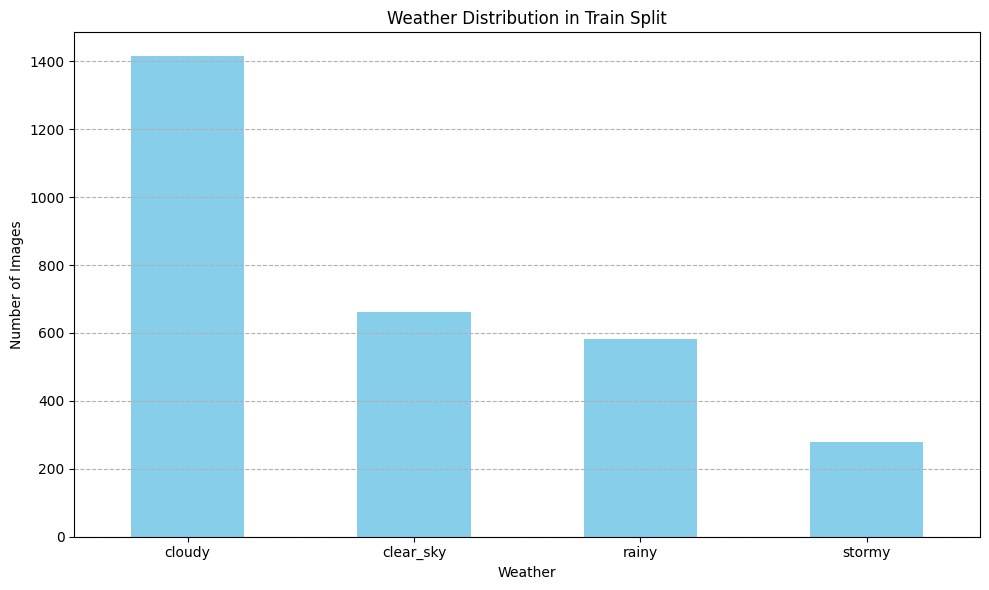


Cloud Types in train:
cloud_type
Stratocumulus     336
Cirrostratus      316
Nimbostratus      298
Altostratus       285
Cumulonimbus      280
Cumulus           270
Altocumulus       265
Stratus           260
Cirrocumulus      198
Cirrus            195
Contrail          151
Cirroculumulus     86
Name: count, dtype: int64


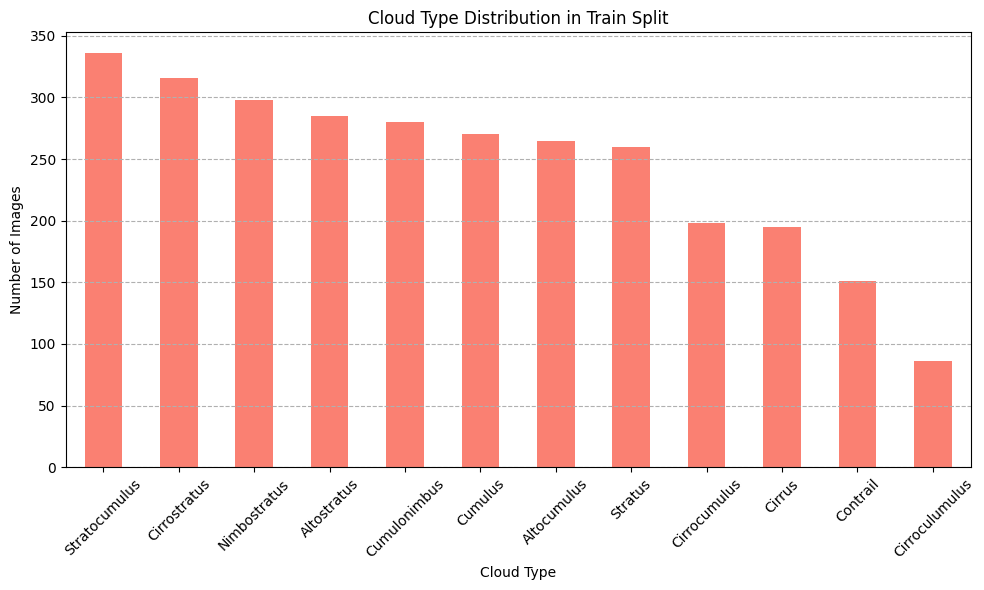


--- Analysing VAL Split ---
Weather Categories in val:
weather
cloudy       277
clear_sky     95
rainy         93
stormy        54
Name: count, dtype: int64


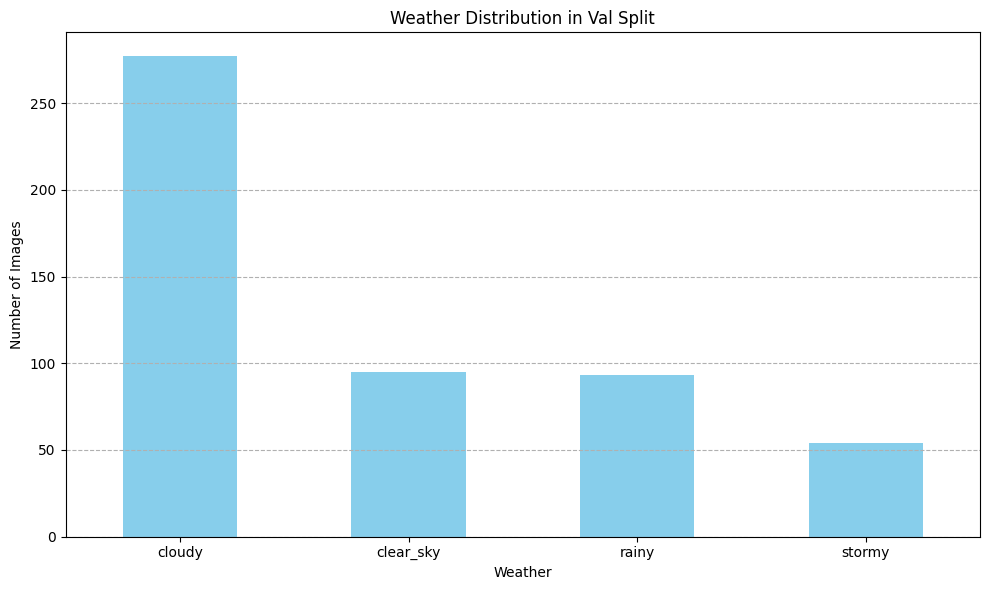


Cloud Types in val:
cloud_type
Stratocumulus     76
Cumulus           58
Cumulonimbus      54
Nimbostratus      50
Altocumulus       45
Cirrostratus      44
Altostratus       43
Cirrocumulus      40
Stratus           39
Cirrus            35
Cirroculumulus    19
Contrail          16
Name: count, dtype: int64


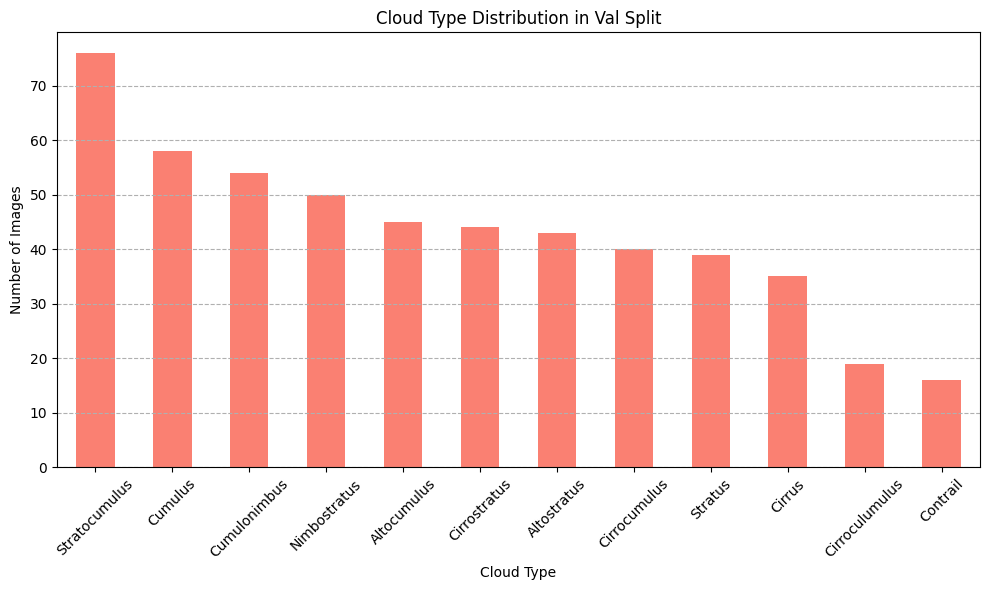


--- Analysing TEST Split ---
Weather Categories in test:
weather
cloudy       244
clear_sky    119
rainy        104
stormy        33
Name: count, dtype: int64


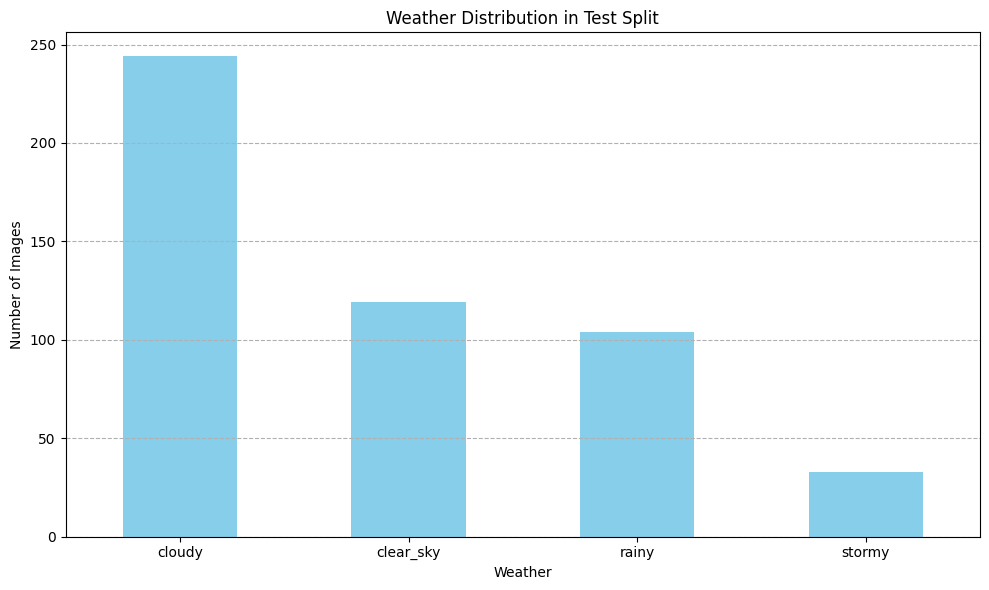


Cloud Types in test:
cloud_type
Stratocumulus     60
Nimbostratus      57
Cirrostratus      55
Altostratus       47
Altocumulus       46
Cumulus           42
Stratus           40
Contrail          33
Cumulonimbus      33
Cirrus            31
Cirrocumulus      30
Cirroculumulus    26
Name: count, dtype: int64


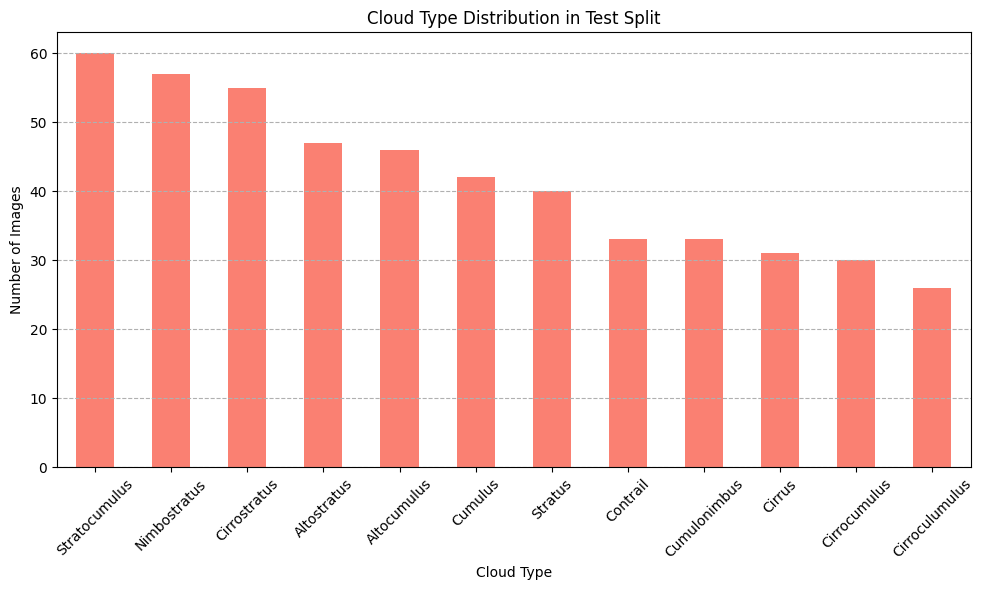


Comparing Weather Distributions:
weather  clear_sky  cloudy  rainy  stormy
split                                    
test           119     244    104      33
train          662    1415    583     280
val             95     277     93      54


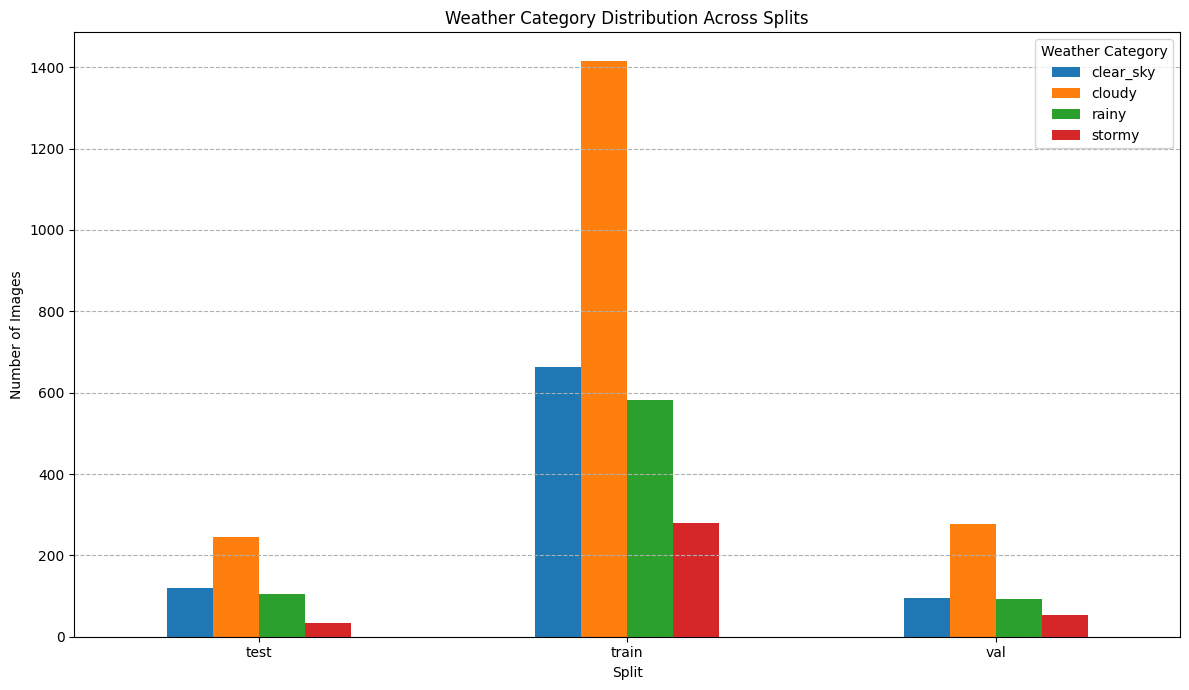


Cloud Type vs Weather Category (All Splits Combined):
weather         clear_sky  cloudy  rainy  stormy
cloud_type                                      
Altocumulus             0     356      0       0
Altostratus             0       0    375       0
Cirroculumulus          0     131      0       0
Cirrocumulus            0     268      0       0
Cirrostratus          415       0      0       0
Cirrus                261       0      0       0
Contrail              200       0      0       0
Cumulonimbus            0       0      0     367
Cumulus                 0     370      0       0
Nimbostratus            0       0    405       0
Stratocumulus           0     472      0       0
Stratus                 0     339      0       0


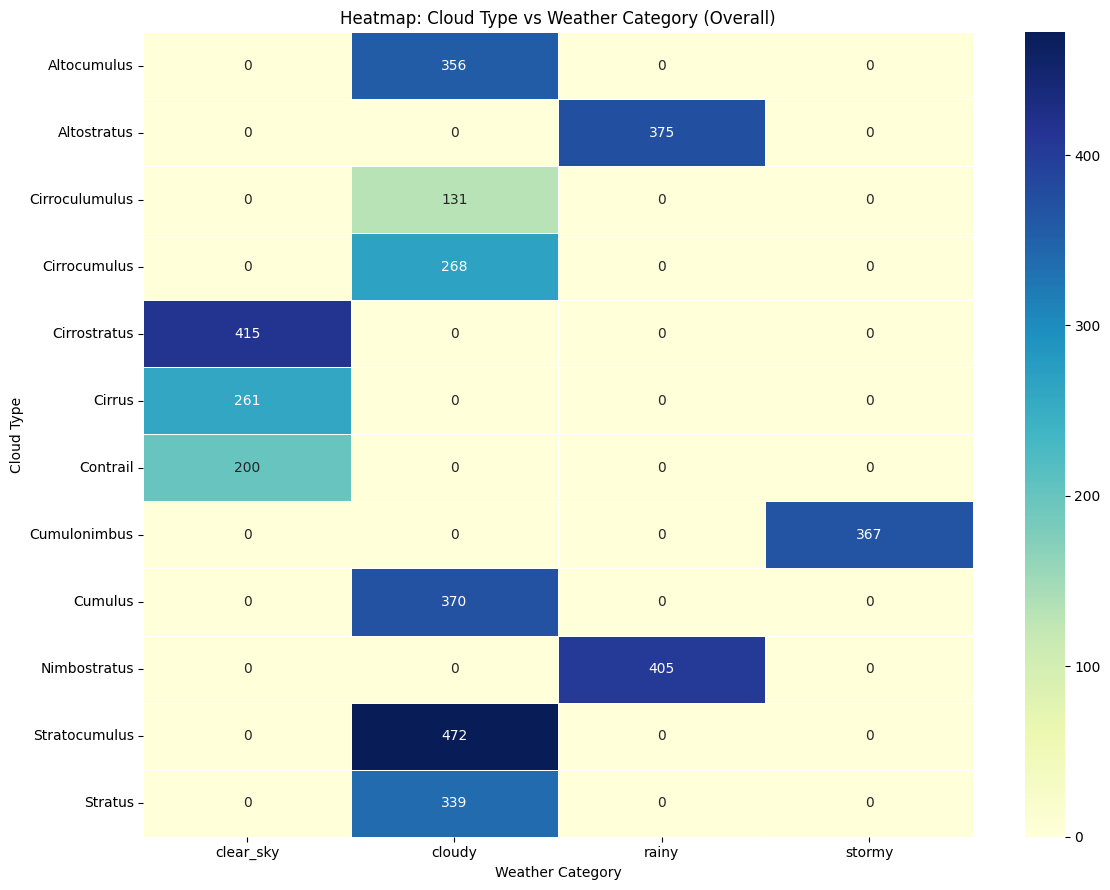

In [5]:
# %% Step 2 - Exploratory Data Analysis (EDA)

print("\n--- Step 2: Exploratory Data Analysis (EDA) ---")

def load_dataset_info(dataset_root: Path) -> pd.DataFrame:
    """
    Walks through the structured dataset directory (train/val/test) and compiles metadata.
    Expected structure: dataset_root/split/weather_category/cloud_type/image
    """
    data = []
    print(f"Loading dataset info from: {dataset_root}")
    splits = [d.name for d in dataset_root.iterdir() if d.is_dir() and d.name in ['train', 'val', 'test']]
    print(f"Found splits: {splits}")

    for split in splits:
        split_path = dataset_root / split
        weather_cats = [d.name for d in split_path.iterdir() if d.is_dir()]
        for weather in weather_cats:
            weather_path = split_path / weather
            cloud_types = [d.name for d in weather_path.iterdir() if d.is_dir()]
            for cloud_type in cloud_types:
                cloud_type_path = weather_path / cloud_type
                images = list(cloud_type_path.glob('*.[jJ][pP][gG]')) + \
                         list(cloud_type_path.glob('*.[jJ][pP][eE][gG]')) + \
                         list(cloud_type_path.glob('*.[pP][nN][gG]'))
                for image_file in images:
                    data.append({
                        'split': split,
                        'weather': weather,
                        'cloud_type': cloud_type,
                        'filename': image_file.name,
                        'filepath': str(image_file.resolve()) # Store full path
                    })
    if not data:
        print("Warning: No data loaded for EDA. Check dataset structure and paths.")
    return pd.DataFrame(data)

def plot_distribution(df: pd.DataFrame, column: str, title_suffix: str, color: str):
    """Helper function to plot value counts for a column."""
    plt.figure(figsize=(10, 6))
    counts = df[column].value_counts()
    counts.plot(kind='bar', color=color)
    plt.title(f"{column.replace('_', ' ').title()} Distribution in {title_suffix}")
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel("Number of Images")
    plt.xticks(rotation=45 if column == 'cloud_type' else 0)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

def perform_detailed_eda(dataset_root: Path):
    """Performs EDA on the merged dataset including train, val, and test splits."""
    df = load_dataset_info(dataset_root)
    if df.empty:
        print("EDA cannot proceed: DataFrame is empty.")
        return

    print("\nDataset Overview:")
    print(df.head())

    # Overall counts
    split_counts = df['split'].value_counts()
    print(f"\nTotal images: {len(df)}")
    for split, count in split_counts.items():
        print(f"{split.title()} images: {count}")

    # Summary counts by split and weather category
    summary = df.groupby(['split', 'weather']).size().unstack(fill_value=0)
    print("\nImage counts by Split and Weather Category:")
    print(summary)
    print("-" * 30)

    # Distributions for each split
    for split_name in ['train', 'val', 'test']:
        print(f"\n--- Analysing {split_name.upper()} Split ---")
        df_split = df[df['split'] == split_name]
        if df_split.empty:
            print(f"No data found for {split_name} split.")
            continue

        print(f"Weather Categories in {split_name}:")
        print(df_split['weather'].value_counts())
        plot_distribution(df_split, 'weather', f"{split_name.title()} Split", 'skyblue')

        print(f"\nCloud Types in {split_name}:")
        print(df_split['cloud_type'].value_counts())
        plot_distribution(df_split, 'cloud_type', f"{split_name.title()} Split", 'salmon')

    # --- Comparative Plots: Weather Distribution across Splits ---
    weather_counts_all_splits = df.groupby('split')['weather'].value_counts().unstack(fill_value=0)
    print("\nComparing Weather Distributions:")
    print(weather_counts_all_splits)

    weather_counts_all_splits.plot(kind='bar', figsize=(12, 7))
    plt.title("Weather Category Distribution Across Splits")
    plt.xlabel("Split")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=0)
    plt.legend(title='Weather Category')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # --- Cross Tab Analysis: Cloud Type vs Weather Category (Overall) ---
    print("\nCloud Type vs Weather Category (All Splits Combined):")
    pivot_table = pd.pivot_table(df, index='cloud_type', columns='weather',
                                 values='filename', aggfunc='count', fill_value=0)
    print(pivot_table)

    plt.figure(figsize=(12, 9))
    sns.heatmap(pivot_table, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5)
    plt.title("Heatmap: Cloud Type vs Weather Category (Overall)")
    plt.xlabel("Weather Category")
    plt.ylabel("Cloud Type")
    plt.tight_layout()
    plt.show()

# Perform EDA on the new dataset structure
print("\nStarting Exploratory Data Analysis (EDA) on the merged dataset...")
perform_detailed_eda(OUTPUT_DIR)


--- Step 3: Model Training and Evaluation ---
Using device: cuda:0
Number of classes for models: 4
Class names: ['clear_sky', 'cloudy', 'rainy', 'stormy']

Dataset sizes:
Train: 2940 images
Val: 519 images
Test: 500 images

Class to index mapping: {'clear_sky': 0, 'cloudy': 1, 'rainy': 2, 'stormy': 3}

--- Training ViT ---


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Starting Training...

Epoch 1/20
---------------


Train Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.2429 Acc: 0.4701


Val Epoch 1:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.1202 Acc: 0.5356
✨ New best validation accuracy: 0.5356

Epoch 2/20
---------------


Train Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.1321 Acc: 0.4816


Val Epoch 2:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.0423 Acc: 0.5472
✨ New best validation accuracy: 0.5472

Epoch 3/20
---------------


Train Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.0495 Acc: 0.5272


Val Epoch 3:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.0296 Acc: 0.5684
✨ New best validation accuracy: 0.5684

Epoch 4/20
---------------


Train Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9918 Acc: 0.5690


Val Epoch 4:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.0137 Acc: 0.5395
Validation accuracy did not improve. Patience: 1/5

Epoch 5/20
---------------


Train Epoch 5:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9353 Acc: 0.6010


Val Epoch 5:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9381 Acc: 0.6089
✨ New best validation accuracy: 0.6089

Epoch 6/20
---------------


Train Epoch 6:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9054 Acc: 0.6075


Val Epoch 6:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9749 Acc: 0.6185
✨ New best validation accuracy: 0.6185

Epoch 7/20
---------------


Train Epoch 7:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.8720 Acc: 0.6224


Val Epoch 7:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.0642 Acc: 0.5183
Validation accuracy did not improve. Patience: 1/5

Epoch 8/20
---------------


Train Epoch 8:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.7518 Acc: 0.6830


Val Epoch 8:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8318 Acc: 0.6686
✨ New best validation accuracy: 0.6686

Epoch 9/20
---------------


Train Epoch 9:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.7037 Acc: 0.7092


Val Epoch 9:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8295 Acc: 0.6647
Validation accuracy did not improve. Patience: 1/5

Epoch 10/20
---------------


Train Epoch 10:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.6822 Acc: 0.7095


Val Epoch 10:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8320 Acc: 0.6782
✨ New best validation accuracy: 0.6782

Epoch 11/20
---------------


Train Epoch 11:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.6536 Acc: 0.7221


Val Epoch 11:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8403 Acc: 0.6686
Validation accuracy did not improve. Patience: 1/5

Epoch 12/20
---------------


Train Epoch 12:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.6226 Acc: 0.7381


Val Epoch 12:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8185 Acc: 0.6763
Validation accuracy did not improve. Patience: 2/5

Epoch 13/20
---------------


Train Epoch 13:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.5965 Acc: 0.7497


Val Epoch 13:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8557 Acc: 0.6609
Validation accuracy did not improve. Patience: 3/5

Epoch 14/20
---------------


Train Epoch 14:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.5628 Acc: 0.7701


Val Epoch 14:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8647 Acc: 0.6859
✨ New best validation accuracy: 0.6859

Epoch 15/20
---------------


Train Epoch 15:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.5170 Acc: 0.7891


Val Epoch 15:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8662 Acc: 0.6898
✨ New best validation accuracy: 0.6898

Epoch 16/20
---------------


Train Epoch 16:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.4915 Acc: 0.7976


Val Epoch 16:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8831 Acc: 0.6782
Validation accuracy did not improve. Patience: 1/5

Epoch 17/20
---------------


Train Epoch 17:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.4730 Acc: 0.8041


Val Epoch 17:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9032 Acc: 0.6744
Validation accuracy did not improve. Patience: 2/5

Epoch 18/20
---------------


Train Epoch 18:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.4656 Acc: 0.8143


Val Epoch 18:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9163 Acc: 0.6686
Validation accuracy did not improve. Patience: 3/5

Epoch 19/20
---------------


Train Epoch 19:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.4684 Acc: 0.8153


Val Epoch 19:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9142 Acc: 0.6724
Validation accuracy did not improve. Patience: 4/5

Epoch 20/20
---------------


Train Epoch 20:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.4576 Acc: 0.8156


Val Epoch 20:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9106 Acc: 0.6705
Validation accuracy did not improve. Patience: 5/5

Early stopping triggered after 20 epochs.

Training complete in 34m 16s
Best Validation Accuracy: 0.6898

Evaluating best model on the Test Set...


Testing:   0%|          | 0/16 [00:00<?, ?it/s]


Final Test Accuracy: 0.6980
Saved best ViT model (based on validation) to /content/drive/MyDrive/Capstone Project/Code & Files/models/best_ViT_val.pth


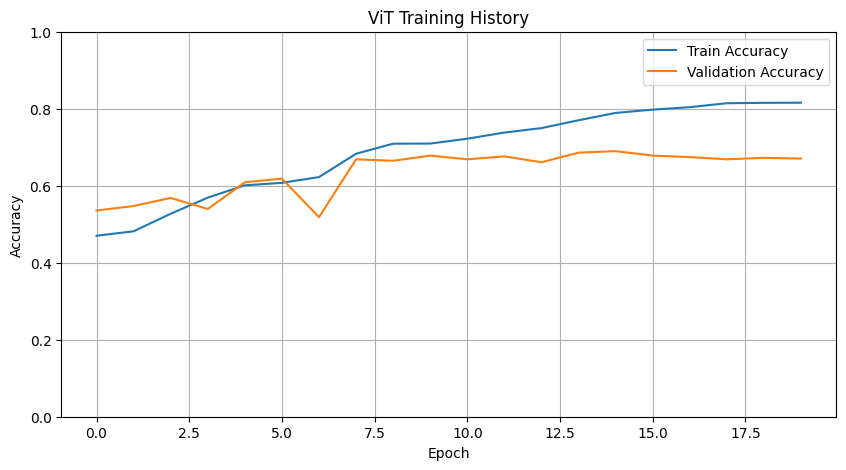


--- Training ResNet50 ---


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 81.2MB/s]


Adjusted final layer for ResNet50.

Starting Training...

Epoch 1/20
---------------


Train Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9398 Acc: 0.6000


Val Epoch 1:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8333 Acc: 0.6455
✨ New best validation accuracy: 0.6455

Epoch 2/20
---------------


Train Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.7839 Acc: 0.6833


Val Epoch 2:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8282 Acc: 0.6782
✨ New best validation accuracy: 0.6782

Epoch 3/20
---------------


Train Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.6894 Acc: 0.7184


Val Epoch 3:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8842 Acc: 0.6378
Validation accuracy did not improve. Patience: 1/5

Epoch 4/20
---------------


Train Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.6222 Acc: 0.7537


Val Epoch 4:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8922 Acc: 0.6744
Validation accuracy did not improve. Patience: 2/5

Epoch 5/20
---------------


Train Epoch 5:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.5508 Acc: 0.7718


Val Epoch 5:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.8829 Acc: 0.6744
Validation accuracy did not improve. Patience: 3/5

Epoch 6/20
---------------


Train Epoch 6:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.4937 Acc: 0.7983


Val Epoch 6:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9824 Acc: 0.6724
Validation accuracy did not improve. Patience: 4/5

Epoch 7/20
---------------


Train Epoch 7:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.4437 Acc: 0.8241


Val Epoch 7:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.0133 Acc: 0.6455
Validation accuracy did not improve. Patience: 5/5

Early stopping triggered after 7 epochs.

Training complete in 4m 6s
Best Validation Accuracy: 0.6782

Evaluating best model on the Test Set...


Testing:   0%|          | 0/16 [00:00<?, ?it/s]


Final Test Accuracy: 0.6880
Saved best ResNet50 model (based on validation) to /content/drive/MyDrive/Capstone Project/Code & Files/models/best_ResNet50_val.pth


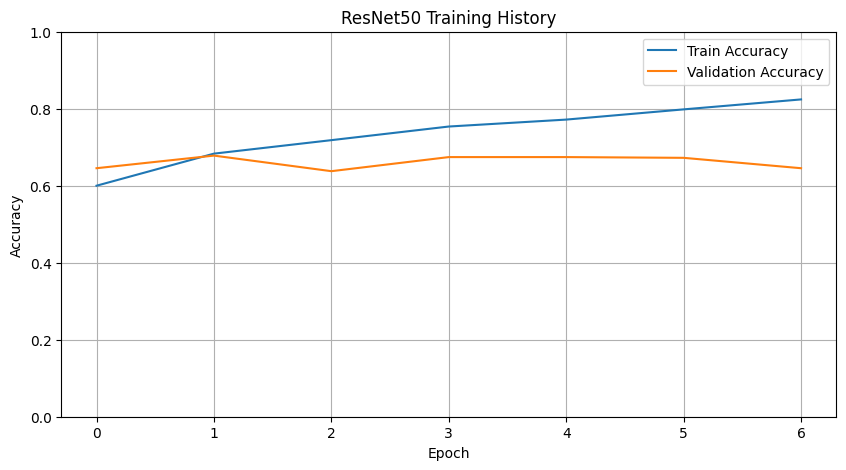


--- Training EfficientNetB0 ---


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


Starting Training...

Epoch 1/20
---------------


Train Epoch 1:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.5187 Acc: 0.4731


Val Epoch 1:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.3086 Acc: 0.5356
✨ New best validation accuracy: 0.5356

Epoch 2/20
---------------


Train Epoch 2:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.0780 Acc: 0.5884


Val Epoch 2:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.1923 Acc: 0.5626
✨ New best validation accuracy: 0.5626

Epoch 3/20
---------------


Train Epoch 3:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9199 Acc: 0.6418


Val Epoch 3:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.0972 Acc: 0.6012
✨ New best validation accuracy: 0.6012

Epoch 4/20
---------------


Train Epoch 4:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.8283 Acc: 0.6735


Val Epoch 4:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.0300 Acc: 0.6127
✨ New best validation accuracy: 0.6127

Epoch 5/20
---------------


Train Epoch 5:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.7545 Acc: 0.6997


Val Epoch 5:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.0334 Acc: 0.6204
✨ New best validation accuracy: 0.6204

Epoch 6/20
---------------


Train Epoch 6:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.6640 Acc: 0.7354


Val Epoch 6:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 1.0578 Acc: 0.6127
Validation accuracy did not improve. Patience: 1/5

Epoch 7/20
---------------


Train Epoch 7:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.6127 Acc: 0.7609


Val Epoch 7:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9918 Acc: 0.6224
✨ New best validation accuracy: 0.6224

Epoch 8/20
---------------


Train Epoch 8:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.5291 Acc: 0.7939


Val Epoch 8:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9781 Acc: 0.6474
✨ New best validation accuracy: 0.6474

Epoch 9/20
---------------


Train Epoch 9:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.5209 Acc: 0.7990


Val Epoch 9:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9872 Acc: 0.6378
Validation accuracy did not improve. Patience: 1/5

Epoch 10/20
---------------


Train Epoch 10:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.5007 Acc: 0.7990


Val Epoch 10:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9791 Acc: 0.6455
Validation accuracy did not improve. Patience: 2/5

Epoch 11/20
---------------


Train Epoch 11:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.5221 Acc: 0.7912


Val Epoch 11:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9812 Acc: 0.6378
Validation accuracy did not improve. Patience: 3/5

Epoch 12/20
---------------


Train Epoch 12:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.5061 Acc: 0.7925


Val Epoch 12:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9935 Acc: 0.6435
Validation accuracy did not improve. Patience: 4/5

Epoch 13/20
---------------


Train Epoch 13:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.4878 Acc: 0.8153


Val Epoch 13:   0%|          | 0/17 [00:00<?, ?it/s]

Val Loss: 0.9748 Acc: 0.6455
Validation accuracy did not improve. Patience: 5/5

Early stopping triggered after 13 epochs.

Training complete in 6m 35s
Best Validation Accuracy: 0.6474

Evaluating best model on the Test Set...


Testing:   0%|          | 0/16 [00:00<?, ?it/s]


Final Test Accuracy: 0.6660
Saved best EfficientNetB0 model (based on validation) to /content/drive/MyDrive/Capstone Project/Code & Files/models/best_EfficientNetB0_val.pth


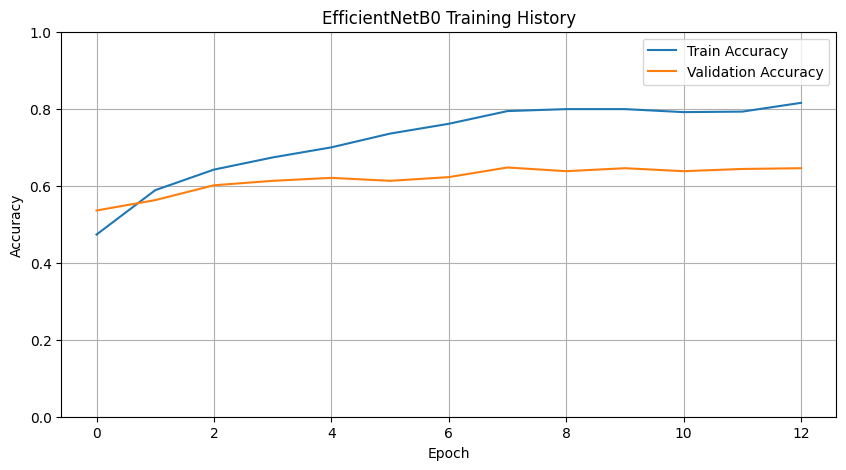


--- Training Results Summary ---
ViT: Final Test Accuracy = 0.6980 (Best val model saved at: /content/drive/MyDrive/Capstone Project/Code & Files/models/best_ViT_val.pth)
ResNet50: Final Test Accuracy = 0.6880 (Best val model saved at: /content/drive/MyDrive/Capstone Project/Code & Files/models/best_ResNet50_val.pth)
EfficientNetB0: Final Test Accuracy = 0.6660 (Best val model saved at: /content/drive/MyDrive/Capstone Project/Code & Files/models/best_EfficientNetB0_val.pth)

🏆 Best overall model based on Test Accuracy: ViT (0.6980)
Saved the overall best model weights to: /content/drive/MyDrive/Capstone Project/Code & Files/models/best_overall_model.pth
Saved training summary to /content/drive/MyDrive/Capstone Project/Code & Files/models/training_results.json


In [6]:
# %% Step 3 - Training Model and Evaluation with Validation

print("\n--- Step 3: Model Training and Evaluation ---")

# Use GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Number of classes for models: {NUM_CLASSES}")
print(f"Class names: {CLASS_NAMES}")

# --- Data Transformations ---
# Increased augmentation for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE[0], scale=(0.7, 1.0)), # Slightly more aggressive crop
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15), # Add rotation
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1), # Add color jitter
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([ # Validation transforms should NOT include augmentation
        transforms.Resize(256), # Keep resize consistent
        transforms.CenterCrop(IMAGE_SIZE[0]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([ # Test transforms same as validation
        transforms.Resize(256),
        transforms.CenterCrop(IMAGE_SIZE[0]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# --- Datasets and DataLoaders ---
try:
    image_datasets = {x: datasets.ImageFolder(OUTPUT_DIR / x, data_transforms[x])
                      for x in ['train', 'val', 'test']}

    # Check if datasets loaded correctly and have samples
    if not image_datasets['train'] or not image_datasets['val'] or not image_datasets['test']:
         raise ValueError("One or more datasets (train/val/test) are empty. Check data directories.")

    # Ensure datasets use the determined CLASS_NAMES for consistency
    for split in ['train', 'val', 'test']:
        if image_datasets[split].classes != CLASS_NAMES:
            print(f"Warning: Class name mismatch in '{split}' dataset. Dataset folders: {image_datasets[split].classes}, Expected: {CLASS_NAMES}")
            # You might need to rebuild the dataset folder structure or remap classes if this happens
            # For now, we assume the structure matches CLASS_NAMES derived earlier

    dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, # Increased batch size slightly
                               shuffle=True if x == 'train' else False, # Only shuffle train
                               num_workers=2, pin_memory=True if device.type == 'cuda' else False) # Use pin_memory on GPU
                   for x in ['train', 'val', 'test']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

    print("\nDataset sizes:")
    for split, size in dataset_sizes.items():
        print(f"{split.title()}: {size} images")
        if size == 0:
            print(f"Warning: {split} dataset is empty!")

    # Verify class mapping
    print(f"\nClass to index mapping: {image_datasets['train'].class_to_idx}")
    if list(image_datasets['train'].class_to_idx.keys()) != CLASS_NAMES:
         print("CRITICAL WARNING: Class mapping discrepancy detected. This may lead to incorrect training/evaluation.")


except Exception as e:
    print(f"\nError creating datasets/dataloaders: {e}")
    print("Training cannot proceed. Check dataset paths and structure.")
    # Optionally, exit or raise the error
    # raise e # Uncomment to stop execution if datasets fail to load

# --- GradCAM Implementation ---
class GradCAM:
    """ Gradient-weighted Class Activation Mapping """
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            # Detach and store activations from the target layer
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            # Store gradients flowing back into the target layer
            self.gradients = grad_out[0].detach()

        handle_forward = self.target_layer.register_forward_hook(forward_hook)
        handle_backward = self.target_layer.register_backward_hook(backward_hook)
        self.hook_handles.extend([handle_forward, handle_backward])

    def remove_hooks(self):
        """ Remove all registered hooks """
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = [] # Clear handles list

    def __call__(self, input_tensor: torch.Tensor, class_idx: Optional[int] = None, retain_graph: bool = False) -> np.ndarray:
        """
        Generates the Grad-CAM heatmap for a given input tensor and class index.
        Args:
            input_tensor: Input tensor (requires_grad=True), typically shape [1, C, H, W].
            class_idx: Index of the target class. If None, uses the predicted class.
            retain_graph: Whether to retain the computation graph after backward pass.
                          Set to True if you need to backpropagate further.
        Returns:
            NumPy array representing the normalized heatmap.
        """
        self.model.zero_grad()
        # Ensure requires_grad is set for input if needed outside this scope
        # input_tensor.requires_grad_(True) # Usually not needed if model parameters have grad

        # Forward pass
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()

        # Target for backward pass: the score of the target class
        # Ensure we handle potential batch outputs, but typically expect batch size 1 here
        target_score = output[:, class_idx]

        # Backward pass to compute gradients w.r.t. the target layer's activations
        self.model.zero_grad() # Zero gradients again just before backward
        target_score.backward(retain_graph=retain_graph)

        # Check if hooks captured gradients and activations
        if self.gradients is None or self.activations is None:
             raise RuntimeError("Hooks did not capture gradients or activations. Check target layer.")
        if self.gradients.shape[0] != input_tensor.shape[0]:
            print(f"Warning: Batch size mismatch (Input: {input_tensor.shape[0]}, Grad: {self.gradients.shape[0]})")
            # Handle potential mismatches if batch > 1, though designed for batch=1
            gradients = self.gradients[0:1] # Take first item gradient
            activations = self.activations[0:1] # Take first item activation
        else:
             gradients = self.gradients
             activations = self.activations

        # Global Average Pooling of gradients
        # Shape: [batch, channels, height, width] -> [batch, channels]
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True) # Keep dim for broadcasting

        # Weighted sum of activation maps
        # Shape: [batch, channels, height, width] * [batch, channels, 1, 1] -> [batch, channels, height, width]
        # Then sum across channels -> [batch, height, width]
        cam = torch.sum(weights * activations, dim=1)

        # Apply ReLU to keep only positive contributions
        cam = torch.relu(cam)

        # Normalize the heatmap to [0, 1] for visualization
        # Operate on a single image heatmap (assuming batch=1 or processing one at a time)
        cam_img = cam[0].cpu().numpy() # Take first item if batch was > 1
        cam_img = cam_img - np.min(cam_img)
        cam_img = cam_img / (np.max(cam_img) + 1e-8) # Avoid division by zero

        return cam_img


# --- Training Function ---
def train_model(
    model: nn.Module,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    dataloaders: Dict[str, DataLoader],
    dataset_sizes: Dict[str, int],
    device: torch.device,
    num_epochs: int = 25, # Increased default epochs
    patience: int = 5 # Early stopping patience
) -> Tuple[nn.Module, float, List[float], List[float]]:
    """
    Trains a model, validates it, implements early stopping, and performs a final test evaluation.

    Args:
        model: The neural network model.
        criterion: The loss function.
        optimizer: The optimization algorithm.
        dataloaders: Dictionary containing 'train', 'val', 'test' dataloaders.
        dataset_sizes: Dictionary containing sizes of 'train', 'val', 'test' datasets.
        device: The device to run training on ('cpu' or 'cuda').
        num_epochs: Total number of epochs to train for.
        patience: Number of epochs to wait for validation accuracy improvement before stopping.

    Returns:
        A tuple containing:
        - The best model (state dict loaded) based on validation accuracy.
        - The final accuracy achieved on the 'test' set using the best model.
        - Training accuracy history per epoch.
        - Validation accuracy history per epoch.
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    epochs_no_improve = 0
    train_acc_history = []
    val_acc_history = []

    # Learning rate scheduler (example: StepLR)
    # Adjust gamma and step_size as needed
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    print("\nStarting Training...")
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 15)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Check if dataloader exists and is not empty
            if phase not in dataloaders or dataset_sizes[phase] == 0:
                print(f"Skipping {phase} phase: Dataloader not found or dataset is empty.")
                continue

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase.title()} Epoch {epoch+1}", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # Track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.title()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store history
            if phase == 'train':
                train_acc_history.append(epoch_acc.item())
                # Step the scheduler after training phase
                if scheduler:
                    scheduler.step()
            else: # phase == 'val'
                val_acc_history.append(epoch_acc.item())
                # Check for improvement and update best model
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    print(f"✨ New best validation accuracy: {best_val_acc:.4f}")
                else:
                    epochs_no_improve += 1
                    print(f"Validation accuracy did not improve. Patience: {epochs_no_improve}/{patience}")

        # Early stopping check
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs.")
            break

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation Accuracy: {best_val_acc:.4f}')

    # --- Final Evaluation on Test Set ---
    print("\nEvaluating best model on the Test Set...")
    # Load best model weights found during validation
    model.load_state_dict(best_model_wts)
    model.eval() # Ensure model is in evaluation mode

    running_corrects_test = 0

    if 'test' in dataloaders and dataset_sizes['test'] > 0:
        with torch.no_grad(): # No need to track gradients for testing
            for inputs, labels in tqdm(dataloaders['test'], desc="Testing", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                running_corrects_test += torch.sum(preds == labels.data)

        test_acc = running_corrects_test.double() / dataset_sizes['test']
        print(f'\nFinal Test Accuracy: {test_acc:.4f}')
    else:
        print("Test set not available or empty. Cannot compute final test accuracy.")
        test_acc = 0.0 # Return 0 if test set is unusable

    return model, float(test_acc), train_acc_history, val_acc_history

# --- Model Training Execution ---

models_to_train = {
    "ViT": lambda: timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=NUM_CLASSES),
    "ResNet50": lambda: models.resnet50(pretrained=True),
    "EfficientNetB0": lambda: timm.create_model('tf_efficientnet_b0_ns', pretrained=True, num_classes=NUM_CLASSES), # Use NoisyStudent version
}

results = {}
best_overall_test_acc = -1.0
best_model_name = None
best_model_instance = None # To hold the actual best model object

# Define loss and optimizer specifics here
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4 # A common starting point
weight_decay = 1e-4 # Add weight decay for regularization

# Ensure dataset loaders were created before proceeding
if 'dataloaders' not in locals():
     print("\nDataloaders not defined. Stopping before training.")
else:
    for model_name, model_creator in models_to_train.items():
        print(f"\n--- Training {model_name} ---")
        gc.collect() # Collect garbage
        torch.cuda.empty_cache() # Clear GPU cache

        model = model_creator()

        # Adjust final layer for ResNet50
        if model_name == "ResNet50":
            num_ftrs = model.fc.in_features
            model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
            print("Adjusted final layer for ResNet50.")

        model = model.to(device)

        # Setup optimizer (AdamW is often good for transformers and modern CNNs)
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

        try:
            # Start training
            trained_model, test_acc, train_hist, val_hist = train_model(
                model, criterion, optimizer, dataloaders, dataset_sizes,
                device, num_epochs=20, patience=5 # Reduced epochs for demo, increase if needed
            )

            model_save_file = MODEL_SAVE_PATH / f"best_{model_name}_val.pth"
            torch.save(trained_model.state_dict(), model_save_file)
            print(f"Saved best {model_name} model (based on validation) to {model_save_file}")

            results[model_name] = {'test_acc': test_acc, 'train_hist': train_hist, 'val_hist': val_hist, 'save_path': str(model_save_file)}

            if test_acc > best_overall_test_acc:
                best_overall_test_acc = test_acc
                best_model_name = model_name
                # Keep the current model instance as the best one *before* moving it to CPU
                best_model_instance = copy.deepcopy(trained_model)


            # --- Plotting Training History ---
            plt.figure(figsize=(10, 5))
            plt.plot(train_hist, label="Train Accuracy")
            plt.plot(val_hist, label="Validation Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.title(f"{model_name} Training History")
            plt.legend()
            plt.grid(True)
            plt.ylim(0, 1) # Set y-axis limits
            plt.show()

        except Exception as train_error:
             print(f"\nError during training {model_name}: {train_error}")
             results[model_name] = {'test_acc': 0, 'train_hist': [], 'val_hist': [], 'save_path': None, 'error': str(train_error)}
        finally:
             # Move model off GPU and clear cache regardless of success/failure
             if 'model' in locals() and isinstance(model, nn.Module):
                  model.cpu()
             del model # Explicitly delete to free memory
             if 'optimizer' in locals():
                 del optimizer
             gc.collect()
             torch.cuda.empty_cache()


    # --- Summary of Results ---
    print("\n--- Training Results Summary ---")
    for name, result in results.items():
        if 'error' in result:
            print(f"{name}: Error during training - {result['error']}")
        elif result['save_path']:
             print(f"{name}: Final Test Accuracy = {result['test_acc']:.4f} (Best val model saved at: {result['save_path']})")
        else:
             print(f"{name}: Training did not complete successfully.")

    if best_model_name:
        print(f"\n🏆 Best overall model based on Test Accuracy: {best_model_name} ({best_overall_test_acc:.4f})")
        # Save the state dict of the best *instance* kept in memory
        best_model_path = MODEL_SAVE_PATH / "best_overall_model.pth"
        torch.save(best_model_instance.state_dict(), best_model_path)
        print(f"Saved the overall best model weights to: {best_model_path}")

        # Save results dictionary
        results_path = MODEL_SAVE_PATH / "training_results.json"
        try:
            # Convert tensor histories to lists for JSON serialization
            for name in results:
                if 'train_hist' in results[name]:
                    results[name]['train_hist'] = [h.item() if isinstance(h, torch.Tensor) else h for h in results[name]['train_hist']]
                if 'val_hist' in results[name]:
                    results[name]['val_hist'] = [h.item() if isinstance(h, torch.Tensor) else h for h in results[name]['val_hist']]
            with open(results_path, 'w') as f:
                json.dump(results, f, indent=4)
            print(f"Saved training summary to {results_path}")
        except Exception as json_err:
            print(f"Error saving training results JSON: {json_err}")

    else:
        print("\nNo best model selected. Check training logs.")

    # Clear the best model instance from memory if no longer needed
    del best_model_instance
    gc.collect()
    torch.cuda.empty_cache()


--- Step 4: Explaining Best Model with GradCAM ---
Loading best overall model from: models\best_overall_model.pth
Determined best model from results.json: ViT (Test Acc: 0.6980)
Using model type: ViT
Using target layer: blocks[-1].norm1 (LayerNorm)
Best model weights loaded successfully for explanation.
GradCAM initialized.

--- Grad-CAM Visualization for TEST Split ---

Visualizing Test Sample 1/5 (True Label: clear_sky [Index: 0])
Attempting GradCAM for predicted class: clear_sky (Index: 0)


C:\Users\prana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Debug GradCAM - Input Tensor Shape: torch.Size([1, 3, 224, 224])
Debug GradCAM - Activations shape: torch.Size([1, 197, 768])
Debug GradCAM - Gradients shape: torch.Size([1, 197, 768])
Debug GradCAM - Using 3D weights calculation (ViT adaptation)
Debug GradCAM - Reshaping ViT CAM to grid size: 14x14


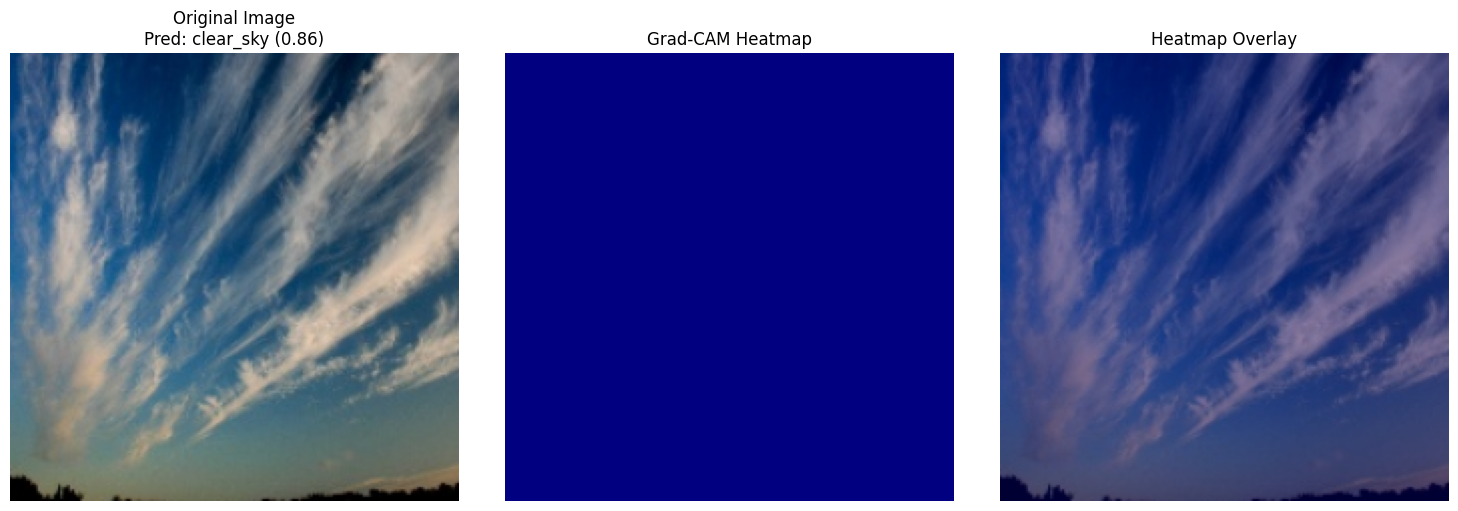


Visualizing Test Sample 2/5 (True Label: clear_sky [Index: 0])
Attempting GradCAM for predicted class: clear_sky (Index: 0)
Debug GradCAM - Input Tensor Shape: torch.Size([1, 3, 224, 224])
Debug GradCAM - Activations shape: torch.Size([1, 197, 768])
Debug GradCAM - Gradients shape: torch.Size([1, 197, 768])
Debug GradCAM - Using 3D weights calculation (ViT adaptation)
Debug GradCAM - Reshaping ViT CAM to grid size: 14x14


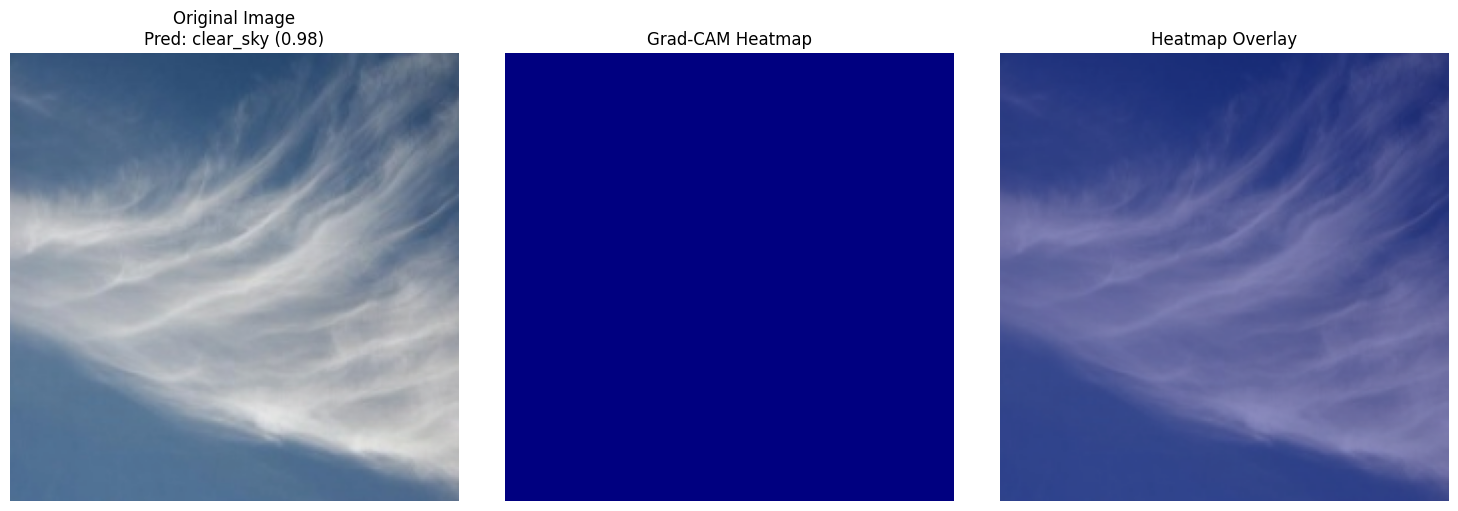


Visualizing Test Sample 3/5 (True Label: clear_sky [Index: 0])
Attempting GradCAM for predicted class: clear_sky (Index: 0)
Debug GradCAM - Input Tensor Shape: torch.Size([1, 3, 224, 224])
Debug GradCAM - Activations shape: torch.Size([1, 197, 768])
Debug GradCAM - Gradients shape: torch.Size([1, 197, 768])
Debug GradCAM - Using 3D weights calculation (ViT adaptation)
Debug GradCAM - Reshaping ViT CAM to grid size: 14x14


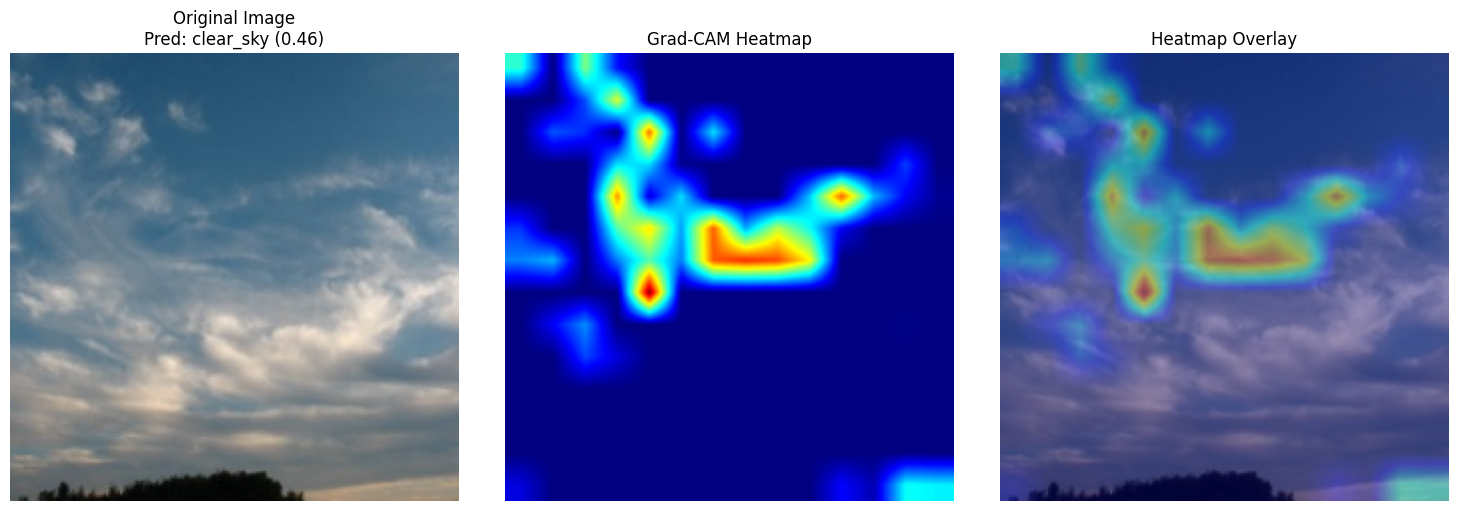


Visualizing Test Sample 4/5 (True Label: clear_sky [Index: 0])
Attempting GradCAM for predicted class: cloudy (Index: 1)
Debug GradCAM - Input Tensor Shape: torch.Size([1, 3, 224, 224])
Debug GradCAM - Activations shape: torch.Size([1, 197, 768])
Debug GradCAM - Gradients shape: torch.Size([1, 197, 768])
Debug GradCAM - Using 3D weights calculation (ViT adaptation)
Debug GradCAM - Reshaping ViT CAM to grid size: 14x14


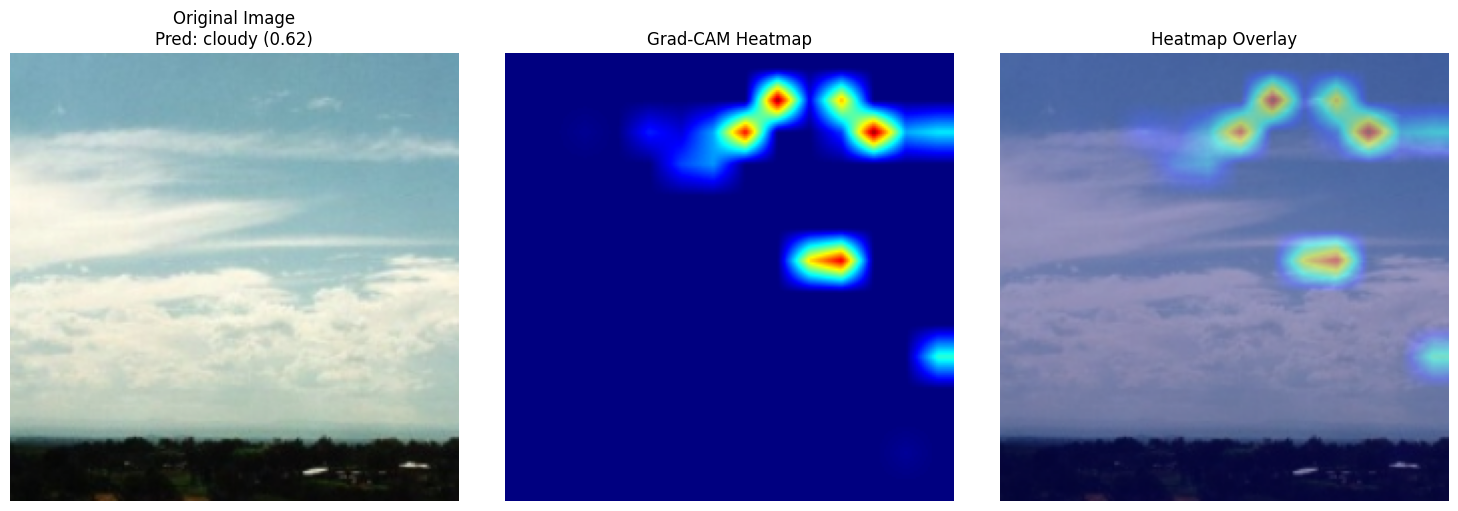


Visualizing Test Sample 5/5 (True Label: clear_sky [Index: 0])
Attempting GradCAM for predicted class: cloudy (Index: 1)
Debug GradCAM - Input Tensor Shape: torch.Size([1, 3, 224, 224])
Debug GradCAM - Activations shape: torch.Size([1, 197, 768])
Debug GradCAM - Gradients shape: torch.Size([1, 197, 768])
Debug GradCAM - Using 3D weights calculation (ViT adaptation)
Debug GradCAM - Reshaping ViT CAM to grid size: 14x14


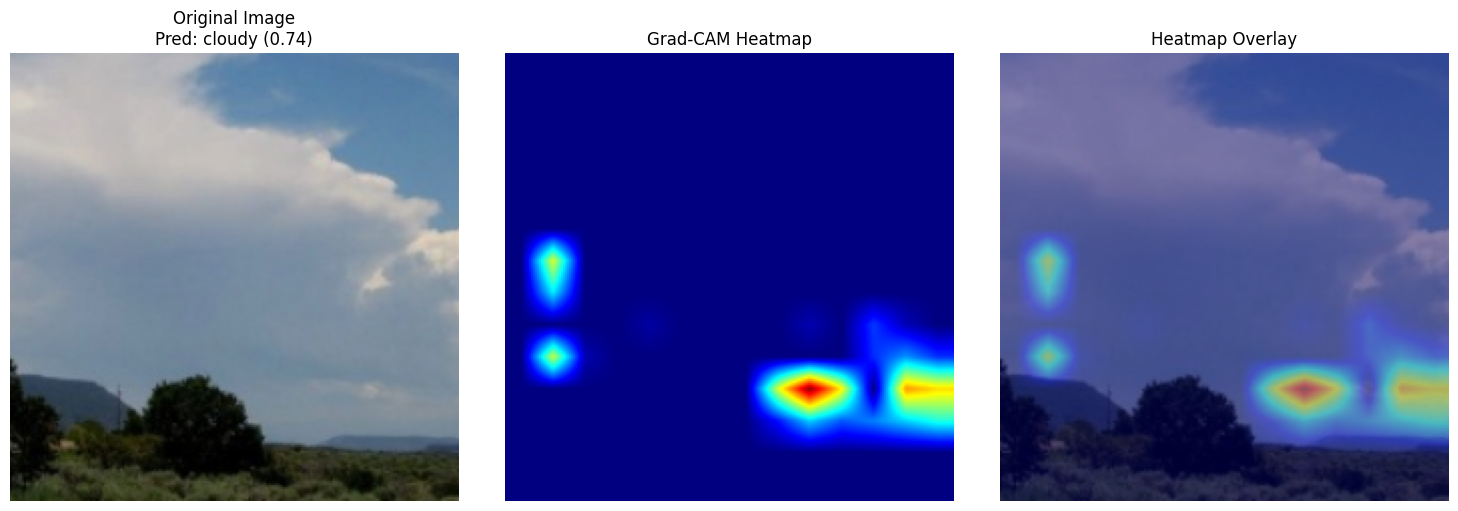

Validation dataloader not found or empty.

--- Step 4 Cleanup ---
Explained model moved to CPU and deleted.
GradCAM instance deleted and hooks removed.


In [5]:
import os
import io # Used in visualization helpers now
import json
from pathlib import Path
import time
import copy
import random

import torch
import torch.nn as nn
import torch.optim as optim # Only needed if re-training here, not typically in Step 4
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import timm
import numpy as np
import cv2
import matplotlib.pyplot as plt
import gc
from PIL import Image # Used in visualization helpers

from typing import List, Dict, Tuple, Optional, Union, Any

if 'MODEL_SAVE_PATH' not in locals(): MODEL_SAVE_PATH = Path("./models")
if 'NUM_CLASSES' not in locals(): NUM_CLASSES = 4
if 'CLASS_NAMES' not in locals():
    try:
       with open(MODEL_SAVE_PATH / "class_names.json", 'r') as f: CLASS_NAMES = json.load(f)
    except: CLASS_NAMES = [f"Class_{i}" for i in range(NUM_CLASSES)] # Fallback
if 'device' not in locals(): device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if 'IMAGE_SIZE' not in locals(): IMAGE_SIZE = (224, 224)
if 'OUTPUT_DIR' not in locals(): OUTPUT_DIR = Path("./datasets/cloudX_improved") # Needed for loading example images


# --- GradCAM Class (Modified to Handle Different Dimensions) ---
class GradCAM:
    """ Gradient-weighted Class Activation Mapping (Modified for Robustness) """
    def __init__(self, model: nn.Module, target_layer: nn.Module):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        # Hooks registered per-call now

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        # Clear previous handles just in case
        self.remove_hooks()
        handle_forward = self.target_layer.register_forward_hook(forward_hook)
        handle_backward = self.target_layer.register_backward_hook(backward_hook)
        self.hook_handles.extend([handle_forward, handle_backward])

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []
        self.gradients = None
        self.activations = None

    def __call__(self, input_tensor: torch.Tensor, class_idx: Optional[int] = None, retain_graph: bool = False) -> np.ndarray:
        """
        Generates the Grad-CAM heatmap for a given input tensor and class index.
        Handles both 4D (CNN) and potentially 3D (Transformer) activations.
        """
        self.model.zero_grad()
        self._register_hooks() # Register hooks fresh for each call

        try:
            output = self.model(input_tensor)
            if class_idx is None:
                class_idx = torch.argmax(output, dim=1).item()

            target_score = output[:, class_idx]
            target_score.backward(retain_graph=retain_graph)

            if self.gradients is None or self.activations is None:
                # Check if target_layer requires grad? Maybe model was in eval with no_grad()?
                if not self.target_layer.weight.requires_grad:
                    print(f"Warning: Target layer '{self.target_layer.__class__.__name__}' parameter requires_grad is False. Gradients might be None.")
                raise RuntimeError("Hooks did not capture gradients or activations. Check target layer & requires_grad status.")

            # --- Move Tensors to CPU Early ---
            # Check if gradients/activations were actually captured before moving
            if self.gradients is not None: gradients_cpu = self.gradients.cpu()
            else: raise RuntimeError("Gradients are None after backward pass.")

            if self.activations is not None: activations_cpu = self.activations.cpu()
            else: raise RuntimeError("Activations are None after backward pass.")


            print(f"Debug GradCAM - Input Tensor Shape: {input_tensor.shape}")
            print(f"Debug GradCAM - Activations shape: {activations_cpu.shape}") # Debug print
            print(f"Debug GradCAM - Gradients shape: {gradients_cpu.shape}")   # Debug print

            # --- Adaptive Pooling/Weighting based on dimension ---
            if gradients_cpu.ndim == 4 and activations_cpu.ndim == 4:
                 # Standard case for CNNs (B, C, H, W)
                 print("Debug GradCAM - Using 4D weights calculation (CNN)")
                 weights = torch.mean(gradients_cpu, dim=(2, 3), keepdim=True) # [B, C, 1, 1]
                 cam = torch.sum(weights * activations_cpu, dim=1) # Weighted sum over channels -> [B, H, W]

            elif gradients_cpu.ndim == 3 and activations_cpu.ndim == 3:
                 # Potential case for Transformers/ViT (B, N, D) where N=num_tokens, D=embed_dim
                 # Adapting Grad-CAM concept: average gradients over token dimension (N)
                 # Weight channels/features (D) by these averaged gradients
                 print("Debug GradCAM - Using 3D weights calculation (ViT adaptation)")
                 weights = torch.mean(gradients_cpu, dim=1, keepdim=True) # Average over N (tokens); shape -> [B, 1, D]

                 # Multiply weights [B, 1, D] by activations [B, N, D] and sum over the feature dimension D
                 cam = torch.sum(weights * activations_cpu, dim=2) # Result shape -> [B, N]

                 # --- Attempt to Reshape ViT CAM to 2D Grid ---
                 # Assumes vit_base_patch16_224 structure. N = H*W + 1 (CLS token)
                 # Image size 224, patch size 16 -> Grid size H=W=224/16=14
                 # Expected N = 14*14 + 1 = 196 + 1 = 197
                 num_tokens = activations_cpu.shape[1]
                 expected_hw = IMAGE_SIZE[0] // 16 # Assuming square patches and patch_size=16
                 expected_num_tokens = (expected_hw * expected_hw) + 1

                 if num_tokens == expected_num_tokens:
                     print(f"Debug GradCAM - Reshaping ViT CAM to grid size: {expected_hw}x{expected_hw}")
                     # Exclude CLS token (assumed at index 0) for spatial map
                     cam = cam[:, 1:].reshape(cam.shape[0], expected_hw, expected_hw) # -> [B, H, W]
                 else:
                      print(f"Debug GradCAM - Warning: Token mismatch (Expected={expected_num_tokens}, Got={num_tokens}). Cannot reshape reliably. Using flat CAM over tokens (excluding first).")
                      if num_tokens > 1:
                          cam = cam[:, 1:] # Exclude first token -> [B, N-1] - Becomes 1D CAM
                      # else cam shape remains [B, N] or potentially [B]

            else:
                 # Handle unexpected dimensions
                 print(f"Debug GradCAM - Error: Unsupported activation/gradient dimensions: Activ={activations_cpu.ndim}D, Grad={gradients_cpu.ndim}D")
                 # Cannot produce meaningful CAM - return a placeholder zero map
                 # Calculate expected low-res map size (e.g., 14x14 for 224/16)
                 h_out, w_out = IMAGE_SIZE[0] // 16, IMAGE_SIZE[1] // 16
                 cam = torch.zeros(input_tensor.shape[0], h_out, w_out)

            # --- Post-processing CAM ---
            cam = torch.relu(cam)

            # Normalize the heatmap to [0, 1] per image
            cam_processed = []
            # Handle potential batch > 1, though visualization assumes 1
            for i in range(cam.shape[0]):
                 cam_img = cam[i].numpy() # Convert tensor slice to numpy

                 # Check if CAM is valid for normalization
                 if cam_img.size > 0 and np.max(cam_img) > np.min(cam_img):
                     # Normalize valid CAM
                     cam_img = cam_img - np.min(cam_img)
                     cam_img = cam_img / (np.max(cam_img) + 1e-8) # Add epsilon for stability
                 elif cam_img.ndim >= 2:
                     # Invalid CAM (e.g., all zeros) but has spatial dims, return zeros of same shape
                     cam_img = np.zeros_like(cam_img)
                 else:
                     # Invalid CAM and no spatial dims (e.g., flattened, empty, scalar)
                     # Create a default small zero map
                     h_out, w_out = IMAGE_SIZE[0] // 16, IMAGE_SIZE[1] // 16
                     cam_img = np.zeros((h_out, w_out))
                 cam_processed.append(cam_img)

            # Visualization expects single image result, return the first one
            final_cam = cam_processed[0] if cam_processed else np.zeros((IMAGE_SIZE[0]//16, IMAGE_SIZE[1]//16))

        except Exception as e_call:
             # Catch errors during the __call__ processing itself
             print(f"Error during GradCAM.__call__: {e_call}")
             import traceback
             traceback.print_exc() # Print detailed traceback for debugging
             # Return a default zero map on error
             h_out, w_out = IMAGE_SIZE[0] // 16, IMAGE_SIZE[1] // 16
             final_cam = np.zeros((h_out, w_out))
        finally:
             # CRITICAL: Always ensure hooks are removed
            self.remove_hooks()

        return final_cam


# %% --- Start of Step 4 Execution Logic ---

print("\n--- Step 4: Explaining Best Model with GradCAM ---")

# Determine which model was best from the results
best_model_path_final = MODEL_SAVE_PATH / "best_overall_model.pth"

# Initialize model and gradcam variables outside the conditional blocks
model_explain = None
gradcam = None
target_layer_explain = None

if best_model_path_final.exists():
    print(f"Loading best overall model from: {best_model_path_final}")
    best_name_found = None
    try:
        # Prefer loading results if available
        results_path = MODEL_SAVE_PATH / "training_results.json"
        if results_path.exists():
            with open(results_path, 'r') as f:
                loaded_results = json.load(f)
            max_acc = -1.0 # Initialize correctly
            for name, res in loaded_results.items():
                # Ensure 'test_acc' exists and is a valid number
                current_acc = res.get('test_acc', -1)
                if isinstance(current_acc, (int, float)) and current_acc > max_acc:
                    max_acc = current_acc
                    best_name_found = name
            if best_name_found:
                print(f"Determined best model from results.json: {best_name_found} (Test Acc: {max_acc:.4f})")
            else:
                print("Could not determine best model from results.json (no valid test_acc found). Falling back.")
        else:
            print("training_results.json not found. Falling back to default assumption (ViT).")

        if best_name_found is None:
             best_name_found = 'ViT' # Fallback if file read fails or no best found

    except Exception as e_res:
        print(f"Error reading training_results.json: {e_res}. Falling back to default assumption (ViT).")
        best_name_found = 'ViT'

    print(f"Using model type: {best_name_found}")

    # --- Instantiate Model Architecture ---
    try:
        target_layer_name_str = None # Store the layer name string for clarity
        if best_name_found == "ViT":
            model_explain = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=NUM_CLASSES)
            target_layer_name_str = 'blocks[-1].norm1'
        elif best_name_found == "ResNet50":
            model_explain = models.resnet50(pretrained=False) # Load without legacy weights arg
            num_ftrs = model_explain.fc.in_features
            model_explain.fc = nn.Linear(num_ftrs, NUM_CLASSES)
            target_layer_name_str = 'layer4[-1]'
        elif best_name_found == "EfficientNetB0":
            model_explain = timm.create_model('tf_efficientnet_b0_ns', pretrained=False, num_classes=NUM_CLASSES)
            # Try common target layer names for EfficientNet B0
            potential_targets = ['conv_head', 'blocks[-1][-1].conv'] # Check structure for others if these fail
            for target_name in potential_targets:
                try:
                    layer_parts = target_name.split('.')
                    module = model_explain
                    for part in layer_parts:
                        if '[' in part and ']' in part:
                           mod_name, idx = part.split('[')
                           idx = int(idx.replace(']', ''))
                           module = getattr(module, mod_name)[idx]
                        else:
                           module = getattr(module, part)
                    target_layer_name_str = target_name
                    print(f"Found potential target layer for EfficientNet: {target_layer_name_str}")
                    break # Stop at the first found target
                except (AttributeError, IndexError, ValueError):
                    continue # Try the next potential target
            if target_layer_name_str is None:
                 print("Warning: Could not automatically find a common target layer for EfficientNetB0.")
                 # Might need manual inspection and setting of target_layer_name_str

        else:
            print(f"Error: Best model name '{best_name_found}' not recognized for loading architecture.")

        # --- Get Target Layer Module and Load Weights ---
        if model_explain and target_layer_name_str:
             # Function to access potentially nested/indexed layers
             def get_layer_from_string(model, layer_str):
                module = model
                parts = layer_str.split('.')
                for part in parts:
                    if '[' in part and ']' in part:
                        mod_name, idx = part.split('[')
                        idx = int(idx.replace(']', ''))
                        module = getattr(module, mod_name)[idx]
                    else:
                        module = getattr(module, part)
                return module

             try:
                 target_layer_explain = get_layer_from_string(model_explain, target_layer_name_str)
                 print(f"Using target layer: {target_layer_name_str} ({target_layer_explain.__class__.__name__})")

                 # Load state dict *after* confirming model and target exist
                 model_explain.load_state_dict(torch.load(best_model_path_final, map_location=device))
                 model_explain = model_explain.to(device)
                 model_explain.eval() # Set to evaluation mode
                 print("Best model weights loaded successfully for explanation.")

                 # --- Setup GradCAM ---
                 try:
                     gradcam = GradCAM(model=model_explain, target_layer=target_layer_explain)
                     print("GradCAM initialized.")
                 except Exception as e_gradcam:
                     print(f"Error initializing GradCAM: {e_gradcam}")
                     gradcam = None # Disable GradCAM if init fails

             except (AttributeError, IndexError, ValueError) as e_layer:
                 print(f"Error accessing target layer '{target_layer_name_str}': {e_layer}")
                 print("Model Structure Snippet (top level):")
                 for name, module in model_explain.named_children(): print(f"- {name}: {module.__class__.__name__}") # Show top level modules
                 target_layer_explain = None
                 model_explain = None # Can't proceed without target layer
                 gradcam = None
        elif model_explain and not target_layer_name_str:
             print("Error: Could not determine target layer string for GradCAM.")
             model_explain = None
             gradcam = None
        # else: model_explain was already None if type was unrecognized

    except Exception as e_load:
         print(f"Error loading model architecture or weights: {e_load}")
         model_explain = None
         gradcam = None

else:
    print(f"Error: Best overall model file not found at '{best_model_path_final}'. Cannot proceed with explanation.")
    # Ensure model_explain and gradcam are None
    model_explain = None
    gradcam = None

# --- Utility Functions for Visualization (Keep as previously defined) ---
def denormalize(tensor: torch.Tensor) -> np.ndarray:
    """Undo normalization for displaying the image."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = tensor.clone().cpu().numpy().transpose(1, 2, 0)
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)
    return np.uint8(255 * img_np)

def visualize_gradcam_with_heatmap(
    input_tensor: torch.Tensor,
    gradcam_instance: Optional[GradCAM], # Allow GradCAM to be None
    model: Optional[nn.Module], # Allow Model to be None
    class_names_list: List[str],
    target_class_idx: Optional[int] = None
    ) -> None:
    """
    Visualizes the original image, GradCAM heatmap, and overlay side-by-side.
    Handles cases where GradCAM or the model might fail/be unavailable.
    """
    if model is None:
        print("Model not available for prediction/visualization.")
        # Maybe show the input tensor if desired?
        plt.figure(figsize=(5, 5))
        try:
            original_img = denormalize(input_tensor)
            plt.imshow(original_img)
            plt.title("Original Image (Model Unavailable)")
            plt.axis('off')
            plt.show()
        except Exception as e_denorm:
            plt.title("Cannot display image (Model Unavailable)")
            print(f"Error denormalizing input tensor: {e_denorm}")
        return

    # --- Get Model Prediction (can proceed even if GradCAM fails) ---
    predicted_class = "N/A"
    prediction_confidence = 0.0
    pred_idx = None
    try:
        input_tensor_dev = input_tensor.unsqueeze(0).to(device) # Add batch dim and move to device
        with torch.no_grad():
            outputs = model(input_tensor_dev)
            pred_probs = torch.softmax(outputs, dim=1)
            pred_prob, pred_idx_tensor = torch.max(pred_probs, 1)
            pred_idx = pred_idx_tensor.item()
            predicted_class = class_names_list[pred_idx]
            prediction_confidence = pred_prob.item()
    except Exception as e_pred:
        print(f"Error during model prediction: {e_pred}")
        predicted_class = "Prediction Failed"

    # --- Get Original Image ---
    try:
        original_img = denormalize(input_tensor) # Denormalize expects C, H, W tensor
        show_original = True
    except Exception as e_denorm:
        print(f"Error denormalizing input image: {e_denorm}")
        original_img = None
        show_original = False

    # --- Compute GradCAM Heatmap (only if gradcam_instance is available) ---
    cam_numpy = None
    overlay = None
    heatmap_color_rgb = None
    gradcam_success = False

    if gradcam_instance is not None and pred_idx is not None: # Also need pred_idx for CAM target
        print(f"Attempting GradCAM for predicted class: {predicted_class} (Index: {pred_idx})")
        try:
            # Force model to eval mode again just before CAM, although it should be already
            model.eval()
            # Ensure requires_grad is okay on the target layer's parameters
            for param in gradcam_instance.target_layer.parameters():
                if not param.requires_grad:
                    # print(f"Warning: Parameter in target layer {gradcam_instance.target_layer.__class__.__name__} does not require grad.")
                    # Attempting to set requires_grad = True if needed, might fail if frozen upstream
                    try: param.requires_grad_(True)
                    except: pass # Ignore if setting fails

            cam_numpy = gradcam_instance(input_tensor_dev, class_idx=target_class_idx if target_class_idx is not None else pred_idx)

            # Check if cam_numpy is valid before resizing
            if cam_numpy is None or cam_numpy.size == 0 or cam_numpy.ndim < 2:
                 print("GradCAM returned invalid output.")
            else:
                # Resize CAM to match original image dimensions (if available)
                target_h, target_w = original_img.shape[0:2] if show_original else IMAGE_SIZE
                heatmap = cv2.resize(cam_numpy, (target_w, target_h), interpolation=cv2.INTER_LINEAR) # Use linear for smoother resize
                heatmap_normalized = np.uint8(255 * np.clip(heatmap, 0, 1)) # Clip before normalizing

                # Apply colormap
                heatmap_color = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)
                heatmap_color_rgb = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) # Convert for matplotlib

                # Create overlay (only if original image is available)
                if show_original and original_img is not None:
                    overlay = cv2.addWeighted(original_img, 0.6, heatmap_color_rgb, 0.4, 0)
                gradcam_success = True

        except Exception as e:
            print(f"Error during GradCAM generation or visualization: {e}")
            # import traceback # Uncomment for detailed debugging if needed
            # traceback.print_exc()
            gradcam_success = False # Ensure flag is False on error
            # CAM variables remain None or outdated
            cam_numpy = None
            overlay = None
            heatmap_color_rgb = None

    # --- Display Results ---
    # Decide layout based on what succeeded
    num_plots = sum([show_original, gradcam_success, gradcam_success]) # Original, Heatmap, Overlay
    if num_plots == 0:
        print("Nothing to display.")
        return
    elif num_plots == 1 and show_original:
         fig, axes = plt.subplots(1, 1, figsize=(5, 5))
         ax = axes
         plot_idx = 0
    elif num_plots >= 2:
         fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
         ax = axes.ravel() # Flatten axes array for easy indexing
         plot_idx = 0
    else: # Only gradcam failed but original didn't show? Should not happen based on logic above.
         print("Unexpected plotting scenario.")
         return


    # Plot Original Image
    if show_original and original_img is not None:
        ax[plot_idx].imshow(original_img)
        ax[plot_idx].set_title(f"Original Image\nPred: {predicted_class} ({prediction_confidence:.2f})")
        ax[plot_idx].axis('off')
        plot_idx += 1
    elif not show_original: # If original failed to load/denormalize but model predicted
        ax[plot_idx].text(0.5, 0.5, f"Original Image Failed to Load\nPred: {predicted_class} ({prediction_confidence:.2f})", ha='center', va='center')
        ax[plot_idx].set_title("Original Image Unavailable")
        ax[plot_idx].axis('off')
        plot_idx += 1


    # Plot Heatmap
    if gradcam_success and heatmap_color_rgb is not None:
        ax[plot_idx].imshow(heatmap_color_rgb)
        ax[plot_idx].set_title("Grad-CAM Heatmap")
        ax[plot_idx].axis('off')
        plot_idx += 1

    # Plot Overlay
    if gradcam_success and overlay is not None:
        ax[plot_idx].imshow(overlay)
        ax[plot_idx].set_title("Heatmap Overlay")
        ax[plot_idx].axis('off')
        plot_idx += 1
    elif not gradcam_success and show_original and plot_idx < num_plots: # Add placeholder if CAM failed but we expect more plots
        ax[plot_idx].text(0.5, 0.5, "GradCAM Failed", ha='center', va='center')
        ax[plot_idx].set_title("GradCAM Unavailable")
        ax[plot_idx].axis('off')
        plot_idx +=1

    plt.tight_layout()
    plt.show()


def process_and_visualize_split(loader: DataLoader, num_samples: int = 5, split_name: str = ""):
    """Processes samples from a dataloader and visualizes GradCAM."""
    if model_explain is None: # Check model first, as it's needed for prediction anyway
        print(f"Skipping visualization for {split_name} split as model is not available.")
        return
    # GradCAM availability checked inside visualize_gradcam_with_heatmap

    print(f"\n--- Grad-CAM Visualization for {split_name.upper()} Split ---")
    count = 0

    # Use the dataloader directly
    for i, (inputs, labels) in enumerate(loader):
        if count >= num_samples:
             break

        # Process one image at a time from the batch for clarity
        # Use try-except block for robustness against potential dataloader issues
        try:
            img_tensor = inputs[0] # Take the first image in the batch
            true_label_idx = labels[0].item()

            # Ensure class index is valid
            if 0 <= true_label_idx < len(CLASS_NAMES):
                 true_label_name = CLASS_NAMES[true_label_idx]
                 print(f"\nVisualizing {split_name} Sample {count+1}/{num_samples} (True Label: {true_label_name} [Index: {true_label_idx}])")
                 visualize_gradcam_with_heatmap(img_tensor, gradcam, model_explain, CLASS_NAMES) # Pass gradcam instance (can be None)
                 count += 1
            else:
                 print(f"Warning: Skipping sample {i} due to invalid true label index: {true_label_idx}")

        except Exception as e_viz_loop:
             print(f"Error processing sample {i} in visualization loop: {e_viz_loop}")
             # Continue to next sample if possible

# --- Re-define Data Transforms and Loaders if Running Standalone ---
# Necessary for process_and_visualize_split to work if not run after Step 3
if 'data_transforms' not in locals():
    data_transforms = {
        'val': transforms.Compose([ # Use 'val' or 'test' transforms
            transforms.Resize(256),
            transforms.CenterCrop(IMAGE_SIZE[0]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(IMAGE_SIZE[0]),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

if 'dataloaders' not in locals():
    dataloaders = {}
    print("Attempting to create dataloaders for visualization...")
    try:
        # Reduced batch size for visualization, no shuffle needed
        for split in ['val', 'test']:
            split_path = OUTPUT_DIR / split
            if split_path.exists() and any(split_path.iterdir()): # Check if directory exists and is not empty
                dataset = datasets.ImageFolder(split_path, data_transforms[split])
                # Important: Ensure dataset uses correct class mapping, might need alignment if run standalone
                # Verify dataset.classes matches CLASS_NAMES; remap if necessary (complex if run fully standalone)
                if hasattr(dataset, 'classes') and dataset.classes != CLASS_NAMES:
                     print(f"Warning: Class name mismatch for '{split}' dataset. Found: {dataset.classes}, Expected: {CLASS_NAMES}")
                if len(dataset) > 0:
                     dataloaders[split] = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=2)
                     print(f"Created '{split}' dataloader with {len(dataset)} images.")
                else:
                     print(f"Dataset directory '{split}' exists but contains no images.")
            else:
                 print(f"Dataset directory '{split}' not found or empty at {split_path}. Cannot create dataloader.")
    except Exception as e_load:
        print(f"Error creating dataloaders: {e_load}")
        # dataloaders might be partially populated or empty


# --- Run GradCAM Visualization ---
# Check if dataloaders AND model are available before calling visualization
if 'dataloaders' in locals() and model_explain is not None:
    # Test Split
    if 'test' in dataloaders and len(dataloaders['test']) > 0:
        process_and_visualize_split(dataloaders['test'], num_samples=5, split_name="Test")
    elif 'test' not in dataloaders:
        print("Test dataloader not found or empty. Cannot run test split visualization.")
    else: # Exists but maybe len==0 if loader created but dataset empty
        print("Test dataloader seems empty.")

    # Validation Split
    if 'val' in dataloaders and len(dataloaders['val']) > 0:
        process_and_visualize_split(dataloaders['val'], num_samples=3, split_name="Validation")
    elif 'val' not in dataloaders:
        print("Validation dataloader not found or empty.")
    else:
         print("Validation dataloader seems empty.")

elif model_explain is None:
    print("Model for explanation ('model_explain') was not loaded. Skipping visualization.")
else: # Dataloaders not created
     print("Dataloaders not available. Skipping visualization.")


# --- Cleanup ---
print("\n--- Step 4 Cleanup ---")
if 'model_explain' in locals() and model_explain is not None:
    model_explain.cpu() # Ensure model is moved to CPU
    del model_explain
    print("Explained model moved to CPU and deleted.")
if 'gradcam' in locals() and gradcam is not None:
     gradcam.remove_hooks() # Explicitly remove hooks
     del gradcam
     print("GradCAM instance deleted and hooks removed.")
# Ensure gc collects memory
gc.collect()
# If using GPU, clear cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache cleared.")

In [16]:
# %% Step 5 - Prediction Testing Script (Standalone)

print("\n--- Step 5: Prediction Testing Script ---")

def predict_image_standalone(image_path: str, model: nn.Module, class_names_list: List[str], device: torch.device):
    """Loads an image, preprocesses it, and returns the predicted class."""
    try:
        # Load image using PIL
        image = Image.open(image_path).convert("RGB")

        # Use the 'val' or 'test' transform for prediction (no augmentation)
        preprocess_predict = data_transforms['test'] # or 'val'

        # Preprocess the image and add batch dimension
        input_tensor = preprocess_predict(image).unsqueeze(0).to(device)

        # Perform inference
        model.eval() # Ensure model is in eval mode
        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.softmax(outputs, dim=1) # Get probabilities
            confidence, pred_index = torch.max(probabilities, 1) # Get top prediction

        predicted_class = class_names_list[pred_index.item()]
        confidence_score = confidence.item()

        return predicted_class, confidence_score

    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return None, 0.0
    except Exception as e:
        print(f"Error predicting image {image_path}: {e}")
        return None, 0.0

# --- Prepare for Standalone Prediction ---
# Reload the best model if not already in memory or run in a separate session
best_model_pred_path = MODEL_SAVE_PATH / "best_overall_model.pth"
if best_model_pred_path.exists():
    # Determine model type again (can reuse logic from explanation step)
    # Or assume the 'best_name_found' is globally known/saved
    if 'best_name_found' not in locals():
        # Re-run detection logic if needed
        max_acc = -1
        best_name_found = 'ViT' # Default
        try:
           with open(MODEL_SAVE_PATH / "training_results.json", 'r') as f:
               loaded_results = json.load(f)
           for name, res in loaded_results.items():
              if 'test_acc' in res and res['test_acc'] > max_acc:
                    max_acc = res['test_acc']
                    best_name_found = name
        except Exception:
            pass # Use default

    print(f"Loading best model ({best_name_found}) for prediction from {best_model_pred_path}")
    # Instantiate architecture
    if best_name_found == "ViT":
        prediction_model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=NUM_CLASSES)
    elif best_name_found == "ResNet50":
        prediction_model = models.resnet50(pretrained=False)
        num_ftrs = prediction_model.fc.in_features
        prediction_model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    elif best_name_found == "EfficientNetB0":
         prediction_model = timm.create_model('tf_efficientnet_b0_ns', pretrained=False, num_classes=NUM_CLASSES)
    else:
         print(f"Error: Model type '{best_name_found}' not recognized for prediction.")
         prediction_model = None

    if prediction_model:
         prediction_model.load_state_dict(torch.load(best_model_pred_path, map_location=device))
         prediction_model.to(device)
         prediction_model.eval()
         print("Prediction model loaded successfully.")
    else:
         print("Could not load prediction model.")

else:
    print("Error: Best model file for prediction not found.")
    prediction_model = None

# Load class names again, robustly
class_names_pred = []
class_name_load_path = MODEL_SAVE_PATH / CLASS_NAME_FILE
try:
     with open(class_name_load_path, "r") as f:
         class_names_pred = json.load(f)
     if not isinstance(class_names_pred, list) or not all(isinstance(s, str) for s in class_names_pred):
         print(f"Warning: Invalid format in {class_name_load_path}. Using default class names.")
         class_names_pred = CLASS_NAMES # Fallback to predefined
     print(f"Loaded class names for prediction: {class_names_pred}")
except Exception as e:
    print(f"Warning: Could not load class names from {class_name_load_path}. Error: {e}. Using default class names.")
    class_names_pred = CLASS_NAMES # Fallback


# Example usage: (replace with actual image path or user input)
if prediction_model and class_names_pred:
    # Find a test image file to use as an example
    example_image_path = None
    try:
       test_img_candidates = list((OUTPUT_DIR / 'test').glob('**/*.[jJ][pP]*[gG]')) + \
                             list((OUTPUT_DIR / 'test').glob('**/*.[pP][nN][gG]'))
       if test_img_candidates:
          example_image_path = str(random.choice(test_img_candidates))
          print(f"Using example image: {example_image_path}")
       else:
           print("Could not find any example image in the test set.")
           # Try to get input path
           input_path = input("Enter the path to an image for prediction: ")
           if Path(input_path).is_file():
                example_image_path = input_path
           else:
                print("Invalid input path.")

    except Exception as find_err:
        print(f"Error finding example image: {find_err}")
        # Ask for path manually
        input_path = input("Enter the path to an image for prediction: ")
        if Path(input_path).is_file():
             example_image_path = input_path
        else:
             print("Invalid input path.")


    if example_image_path:
        predicted_label, confidence = predict_image_standalone(
            example_image_path,
            prediction_model,
            class_names_pred,
            device
        )

        if predicted_label:
            print(f"\nPrediction for '{Path(example_image_path).name}':")
            print(f"-> Predicted Weather Category: {predicted_label}")
            print(f"-> Confidence: {confidence:.4f}")
        else:
            print("Prediction failed.")
    else:
        print("No valid image path provided for prediction testing.")


# Clean up prediction model from memory
if 'prediction_model' in locals():
    prediction_model.cpu()
    del prediction_model
gc.collect()
torch.cuda.empty_cache()


--- Step 5: Prediction Testing Script ---
Loading best model (ViT) for prediction from /content/drive/MyDrive/Capstone Project/Code & Files/models/best_overall_model.pth
Prediction model loaded successfully.
Loaded class names for prediction: ['clear_sky', 'cloudy', 'rainy', 'stormy']
Using example image: /content/drive/MyDrive/Capstone Project/Code & Files/datasets/cloudX_improved/test/rainy/Nimbostratus/Ns-N179.jpg

Prediction for 'Ns-N179.jpg':
-> Predicted Weather Category: clear_sky
-> Confidence: 0.9375


Successfully loaded results from models\training_results.json
Found valid data for model: ViT
Found valid data for model: ResNet50
Found valid data for model: EfficientNetB0


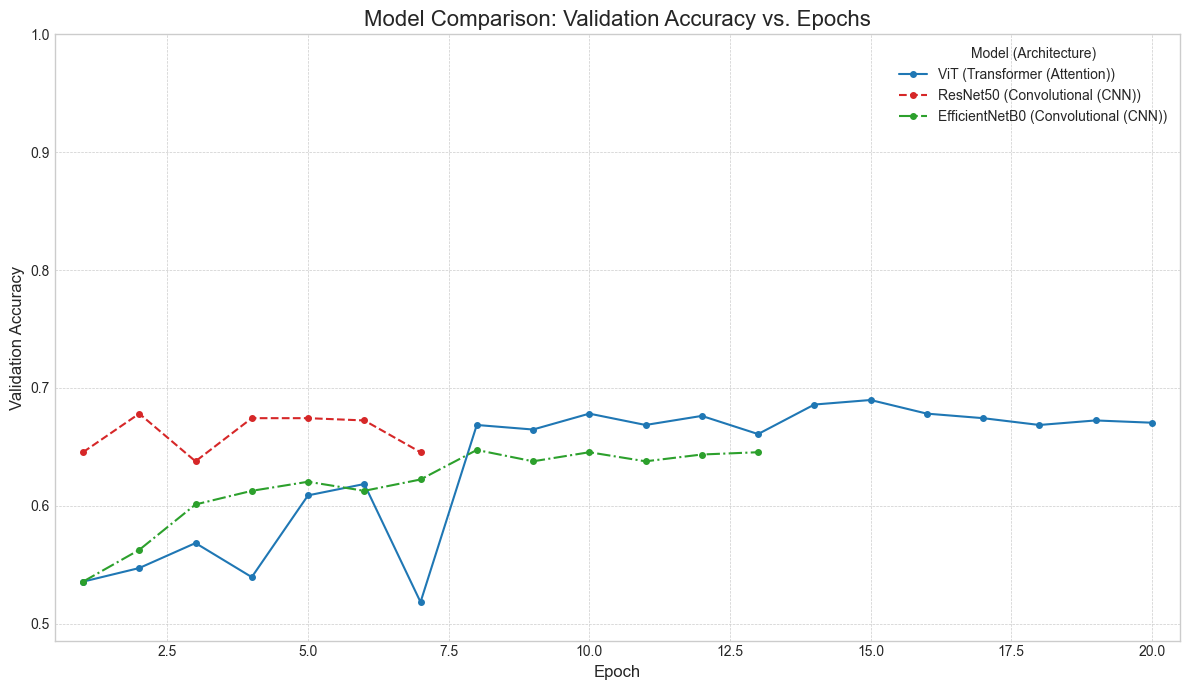

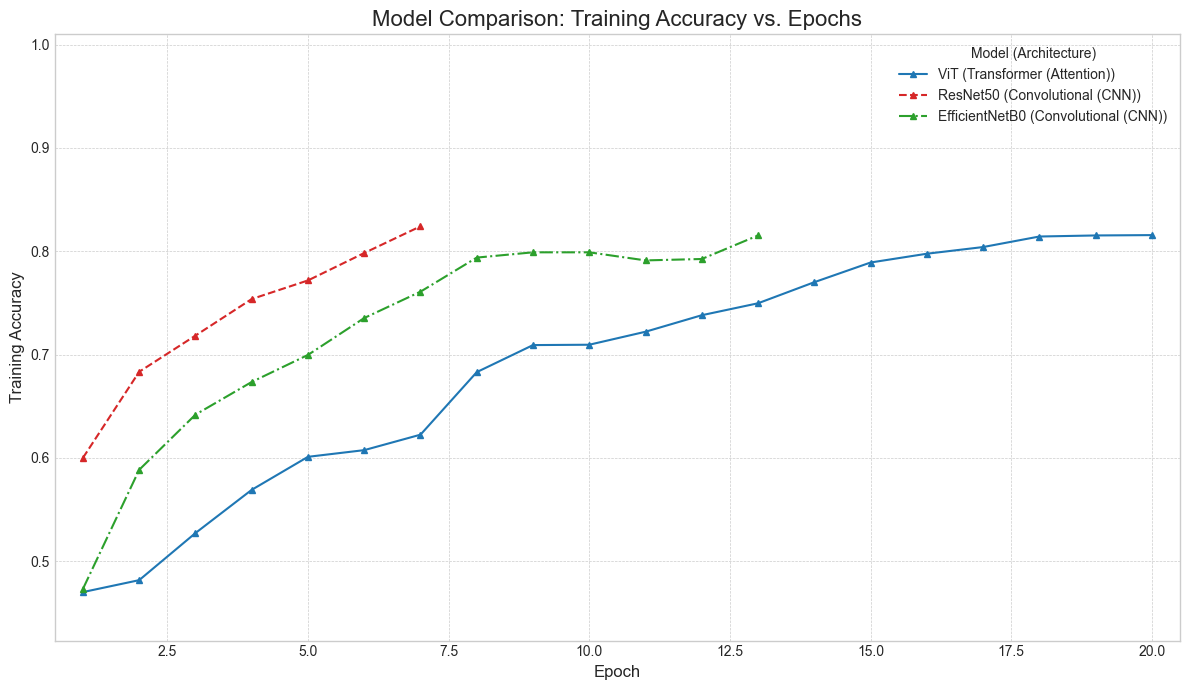

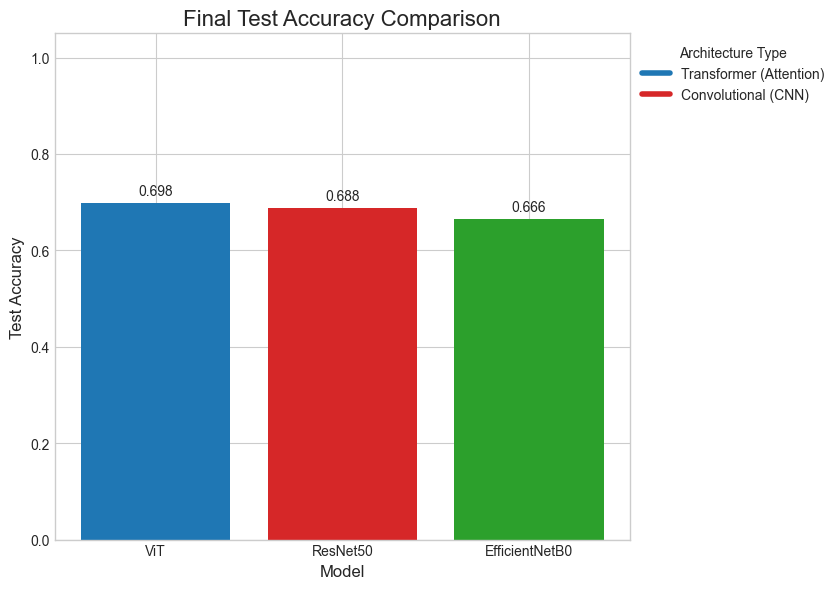


--- Summary Statistics ---
         Model            Architecture  Epochs Trained Final Train Acc Final Val Acc Test Accuracy
           ViT Transformer (Attention)              20          0.8156        0.6705        0.6980
      ResNet50     Convolutional (CNN)               7          0.8241        0.6455        0.6880
EfficientNetB0     Convolutional (CNN)              13          0.8153        0.6455        0.6660


In [ ]:
# %% Model Comparison and Visualization Script

import json
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import numpy as np # For standard deviation calculation

# --- Configuration ---
# Ensure this path points to where your results file is saved
if 'MODEL_SAVE_PATH' not in locals():
    MODEL_SAVE_PATH = Path("./models")
RESULTS_FILE = MODEL_SAVE_PATH / "training_results.json"

# Define architectural characteristics (adjust if you used different models)
MODEL_ARCH_INFO = {
    "ViT": {"type": "Transformer (Attention)", "color": "tab:blue", "linestyle": "-"},
    "ResNet50": {"type": "Convolutional (CNN)", "color": "tab:red", "linestyle": "--"},
    "EfficientNetB0": {"type": "Convolutional (CNN)", "color": "tab:green", "linestyle": "-."}
    # Add other models if you trained more
}

# --- Load Data ---
try:
    with open(RESULTS_FILE, 'r') as f:
        results_data = json.load(f)
    print(f"Successfully loaded results from {RESULTS_FILE}")
except FileNotFoundError:
    print(f"Error: Results file not found at {RESULTS_FILE}")
    exit()
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {RESULTS_FILE}. Check file integrity.")
    exit()
except Exception as e:
    print(f"An unexpected error occurred while loading results: {e}")
    exit()

# --- Data Validation and Preparation ---
valid_models = {}
all_epochs_train = []
all_epochs_val = []

for model_name, data in results_data.items():
    if 'train_hist' in data and 'val_hist' in data and 'test_acc' in data:
        # Basic validation: ensure histories are lists of numbers
        if (isinstance(data['train_hist'], list) and
            isinstance(data['val_hist'], list) and
            isinstance(data['test_acc'], (int, float)) and
            all(isinstance(x, (int, float)) for x in data['train_hist']) and
            all(isinstance(x, (int, float)) for x in data['val_hist'])):

            valid_models[model_name] = data
            # Store epoch lengths for plotting limits
            all_epochs_train.append(len(data['train_hist']))
            all_epochs_val.append(len(data['val_hist']))
            print(f"Found valid data for model: {model_name}")
        else:
            print(f"Warning: Invalid data format found for model '{model_name}'. Skipping.")
    else:
        print(f"Warning: Missing required keys ('train_hist', 'val_hist', 'test_acc') for model '{model_name}'. Skipping.")

if not valid_models:
    print("Error: No valid model data found in the results file. Cannot generate plots.")
    exit()

# Determine max epochs for x-axis limits
max_epochs = max(max(all_epochs_train), max(all_epochs_val)) if all_epochs_train and all_epochs_val else 10 # Default limit

# --- Plot 1: Validation Accuracy Comparison ---
plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style
fig1, ax1 = plt.subplots(figsize=(12, 7))

for model_name, data in valid_models.items():
    epochs = range(1, len(data['val_hist']) + 1)
    arch_info = MODEL_ARCH_INFO.get(model_name, {"type": "Unknown", "color": "grey", "linestyle": ":"}) # Fallback style
    label = f"{model_name} ({arch_info['type']})"
    ax1.plot(
        epochs,
        data['val_hist'],
        label=label,
        color=arch_info['color'],
        linestyle=arch_info['linestyle'],
        marker='o', # Add markers
        markersize=4 # Smaller markers
    )

ax1.set_title('Model Comparison: Validation Accuracy vs. Epochs', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Validation Accuracy', fontsize=12)
ax1.set_xlim(0.5, max_epochs + 0.5) # Adjust x-axis limits
ax1.set_ylim(min(0.5, min(data['val_hist'])-0.05 if data['val_hist'] else 0.5) , 1.0) # Dynamic lower limit, max at 1.0
ax1.legend(fontsize=10, title="Model (Architecture)")
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- Plot 2: Training Accuracy Comparison ---
fig2, ax2 = plt.subplots(figsize=(12, 7))

for model_name, data in valid_models.items():
    epochs = range(1, len(data['train_hist']) + 1)
    arch_info = MODEL_ARCH_INFO.get(model_name, {"type": "Unknown", "color": "grey", "linestyle": ":"})
    label = f"{model_name} ({arch_info['type']})"
    ax2.plot(
        epochs,
        data['train_hist'],
        label=label,
        color=arch_info['color'],
        linestyle=arch_info['linestyle'],
        marker='^', # Different marker
        markersize=4
    )

ax2.set_title('Model Comparison: Training Accuracy vs. Epochs', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Training Accuracy', fontsize=12)
ax2.set_xlim(0.5, max_epochs + 0.5)
ax2.set_ylim(min(0.5, min(data['train_hist'])-0.05 if data['train_hist'] else 0.5) , 1.01) # Dynamic lower limit, allow slightly > 1 if rounding issues
ax2.legend(fontsize=10, title="Model (Architecture)")
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# --- Plot 3: Final Test Accuracy Comparison (Bar Chart) ---
model_names = list(valid_models.keys())
test_accuracies = [valid_models[name]['test_acc'] for name in model_names]
colors = [MODEL_ARCH_INFO.get(name, {"color": "grey"})["color"] for name in model_names]
arch_types = [MODEL_ARCH_INFO.get(name, {"type": "Unknown"})["type"] for name in model_names]

fig3, ax3 = plt.subplots(figsize=(10, 6))
bars = ax3.bar(model_names, test_accuracies, color=colors)

ax3.set_title('Final Test Accuracy Comparison', fontsize=16)
ax3.set_xlabel('Model', fontsize=12)
ax3.set_ylabel('Test Accuracy', fontsize=12)
ax3.set_ylim(0, 1.05) # Extend ylim slightly above 1.0

# Add accuracy values on top of bars
for bar, acc, arch in zip(bars, test_accuracies, arch_types):
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{acc:.3f}', va='bottom', ha='center', fontsize=10)
    # Optionally add architecture type below name (might get crowded)
    # ax3.text(bar.get_x() + bar.get_width()/2.0, -0.05, f'({arch})', va='top', ha='center', fontsize=9, color='dimgrey')

# Add a custom legend for architecture types (using dummy lines)
legend_elements = []
added_types = set()
for name, info in MODEL_ARCH_INFO.items():
    if name in valid_models and info["type"] not in added_types: # Only add legend for plotted models and unique types
        legend_elements.append(plt.Line2D([0], [0], color=info["color"], lw=4, label=info["type"]))
        added_types.add(info["type"])
if legend_elements:
    ax3.legend(handles=legend_elements, title="Architecture Type", loc='upper left', bbox_to_anchor=(1, 1))


plt.xticks(rotation=0) # Keep names horizontal if not too many
plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend outside plot area
plt.show()

# --- Optional: Print Summary Statistics ---
print("\n--- Summary Statistics ---")
summary_data = []
for name, data in valid_models.items():
    arch_info = MODEL_ARCH_INFO.get(name, {"type": "Unknown"})
    val_acc_final = data['val_hist'][-1] if data['val_hist'] else None
    train_acc_final = data['train_hist'][-1] if data['train_hist'] else None
    epochs_trained = len(data['val_hist']) # Assuming validation ran every epoch

    summary_data.append({
        "Model": name,
        "Architecture": arch_info['type'],
        "Epochs Trained": epochs_trained,
        "Final Train Acc": f"{train_acc_final:.4f}" if train_acc_final is not None else "N/A",
        "Final Val Acc": f"{val_acc_final:.4f}" if val_acc_final is not None else "N/A",
        "Test Accuracy": f"{data['test_acc']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))